In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/indiv_dim/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import os
from abc import ABC, abstractmethod
import h5py
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Union
from pathlib import Path
from scipy import stats
from dataclasses import dataclass
from src.utils._config import *
from src.utils._io import *
from src.utils.plot import *
from src.utils.binning import *
from src.spectra._definition import *
from src.idm._definition import *
import argparse
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm


In [2]:
# IDM visualization
from matplotlib.colors import LinearSegmentedColormap
def save_matrix(matrix, filename='matrix.svg', style='nature'):
    """Save matrix as clean SVG without margins."""
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # Colormap options
    if style == 'redblue':
        # Red-Blue diverging
        cmap = LinearSegmentedColormap.from_list('nature_rb', 
            ['#3B4992', '#FFFFFF', '#EE0000'])
    elif style == 'coolwarm':
        # More subtle red-blue diverging
        cmap = 'RdBu_r'
    elif style == 'purpleorange':
        cmap = 'PuOr'
    else:
        # Single-color gradient (blue)
        cmap = LinearSegmentedColormap.from_list('nature_blue',
            ['#FFFFFF', '#2B5A9B'])
    
    ax.imshow(matrix, cmap=cmap, vmax=1, vmin=-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

def zscore_matrix(matrix):
    """Z-score matrix."""
    return (matrix - np.mean(matrix)) / np.std(matrix)

def scale_matrix(matrix):
    """Scale to [-1, 1]"""
    return 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix)) - 1
    
def triu_to_matrix(flat_vals, n):
    """Convert flattened upper triangle to symmetric matrix."""
    matrix = np.zeros((n, n))
    triu_idx = np.triu_indices_from(matrix, k=1)
    matrix[triu_idx] = flat_vals
    matrix = matrix + matrix.T
    np.fill_diagonal(matrix, 1.0)
    return matrix

In [3]:
rois = ['occipital', 'ventral', 'temporal', 'semantic', 'pmc']
# rois_names = {'occipital': 'OccC',
#               'ventral': 'VTC',
#               'temporal': 'LTC',
#               'semantic': 'SMC'}
rois_names = {'occipital': 'early',
              'ventral': 'ventral',
              'temporal': 'lateral',
              'semantic': 'temporoparietal',
              'pmc': 'posteromedial'}

HOME_DIR = Path("/data/chan21/idim-debug-spectra/")
idm_roi_colors = sns.color_palette("magma", len(rois))

mpl.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")
bin_strategy = BinStrategy(
            type='logarithmic',
            density=3,
            start=1,
            stop=10_000
        )


roi_corrs = {}
roi_corrs_isc = {}
roi_split_corrs = {}
roi_split_corrs_isc = {}

roi_perm_corrs = {roi: [] for roi in rois}
roi_perm_corrs_isc = {roi: [] for roi in rois}
roi_perm_split_corrs = {roi: [] for roi in rois}
roi_perm_split_corrs_isc = {roi: [] for roi in rois}

roi_boot_corrs = {roi: [] for roi in rois}
roi_boot_corrs_isc = {roi: [] for roi in rois}
roi_split_boot_corrs = {roi: [] for roi in rois}
roi_split_boot_corrs_isc = {roi: [] for roi in rois}
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}


In [5]:
def get_min_length(h5_data_path, subjects, movies):
    """Calculate minimum length across all subject pairs and movies."""
    try:
        with h5py.File(h5_data_path, 'r') as h5f:
            min_length = np.min([
                h5f[f"data/sub-NSD103_sub-NSD104_{movie}"]["observed"].shape[0] 
                for movie in movies
            ])
        return min_length
    except Exception as e:
        print(f"Error calculating min_length: {e}")
        # Return a default value or raise exception
        raise

def compute_idm_fp(args, movie=None):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    analysis = IDMAnalysis(cache, bin_strategy)
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path
    print(h5_data_path)

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)
    
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})


    if movie is not None:
        idms = []
        for movie in config.movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            with h5py.File(h5_data_path, 'r') as h5f:
                for i, i_subject in enumerate(subjects):
                    for j, j_subject in enumerate(subjects[i+1:], i+1):
                        spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                        for n_bin, bin_id in enumerate(unique_bins):
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                idms.append(np.moveaxis(all_spectra, -1, 0))
        return analysis, idms, anat_matrices

    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None

    idm_series = {}
    with h5py.File(h5_data_path, 'r') as h5f:
        # Initialize array to store all spectra    
        for movie in movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            # Load spectra for each subject pair
            for i, i_subject in enumerate(subjects):
                for j, j_subject in enumerate(subjects[i+1:], i+1):
                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                    for n_bin, bin_id in enumerate(unique_bins):
                        try:
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                        except Exception as e:
                            continue
                            #print(f"Error loading data for {i_subject}_{j_subject}_{movie}: {e}")
            idm_series[movie] = all_spectra

    idm_even_series = np.nanmean([idm_series[movie] for movie in movies[::2]], axis=0)
    idm_odd_series = np.nanmean([idm_series[movie] for movie in movies[1::2]], axis=0)
    
    even_idm, odd_idm = np.moveaxis(idm_even_series, -1, 0), np.moveaxis(idm_odd_series, -1, 0)
    if args.motion:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins
    else:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, unique_bins


for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/data/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )

    analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins = compute_idm_fp(args)
    movies = list(motion_matrices[0].keys())
    even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
    odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
    even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
    odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)

    if args.isc:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            _, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            corr, res1, res2 = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_anat),
                get_upper_triangle(odd_anat))
            correlations.append(corr)
            residual1.append(res1)
            residual2.append(res2)
        roi_corrs_isc[roi] = correlations
        print(roi, correlations)
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs_isc[roi] = diagonals
    else:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            # # Visualization
            # idm_e = - zscore_matrix(even_idm[n_bin])
            # idm_o = - zscore_matrix(odd_idm[n_bin])
            # # Set diagonal to 0
            # np.fill_diagonal(idm_e, np.min(idm_e))
            # np.fill_diagonal(idm_o, np.min(idm_o))
            # save_matrix(idm_e, filename=f"idm_even_diff_{n_bin}.svg", style='coolwarm')
            # save_matrix(idm_o, filename=f"idm_odd_diff_{n_bin}.svg", style='coolwarm')
            # if n_bin == 3:
            #     break
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            corr, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            correlations.append(corr)
            residual1.append(rx)
            residual2.append(ry)
        roi_corrs[roi] = correlations
        print(roi, correlations)
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs[roi] = diagonals




/data/chan21/idim-debug-spectra/results/cov_occipital_functional_perm/eigenspectra.h5
occipital [0.661156227398119, 0.7724906001555565, 0.6291068892836603, 0.6033951867757881, 0.598070284647162, 0.4775458260629735, 0.27885897479042465, 0.1882628989704964, 0.1458292778810037]
/data/chan21/idim-debug-spectra/results/cov_ventral_functional_perm/eigenspectra.h5
ventral [0.7526823703306523, 0.6086406750478617, 0.5618554039869742, 0.3953495140319434, 0.45958746531988987, 0.3954341168620773, 0.2770211005098543, 0.26589686238184046, 0.15193288325881077]
/data/chan21/idim-debug-spectra/results/cov_temporal_functional_perm/eigenspectra.h5
temporal [0.6450757862752026, 0.7435575602875069, 0.4232438003516094, 0.485940212872001, 0.4020920211822926, 0.3359895175213401, 0.1892002795277508, 0.19519136314147983, 0.10466413522465154]
/data/chan21/idim-debug-spectra/results/cov_semantic_functional_perm/eigenspectra.h5
semantic [0.5074007735706775, 0.5888251881801951, 0.42733989337411316, 0.35312676079640

- Compute bootstrapped IDM correlations

In [7]:


def bootstrap_idm_series(analysis, args, n_bootstraps=1000):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)

    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
        even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
        even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
        odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)
    else:
        motion_matrices = nuisance_matrices.get('motion', {})
        even_motion1 = np.nanmean([motion_matrices[m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[m] for m in movies[1::2]], axis=0)
            
    n_bins = len(unique_bins)

    bootstrapped_correlations = [] 
    for boot_idx in tqdm(range(n_bootstraps)):
        if args.isc:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_fp_isc_{str(boot_idx)}.pkl"
        else:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_{str(boot_idx)}.pkl"
        if os.path.exists(file):
            with open(file, "rb") as f:
                bootstrapped_series, subject_idx = pickle.load(f)
            boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
            boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
            boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
            boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
            bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
            if args.isc:
                bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                        elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    _, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    r, _, _ = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                    corr[n_bin] = r
            else: 
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    r, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    corr[n_bin] = r
            bootstrapped_correlations.append(corr)
            continue
        
        bootstrapped_series = {}
        subject_idx = np.random.choice(n_subjects, size=int(n_subjects*0.9), replace=True)
        if anat_matrices:
            bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
        with h5py.File(h5_data_path, 'r') as h5f:
            for movie in movies:
                all_spectra = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9), len(unique_bins)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if i_subject != j_subject:
                            try:
                                spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                            except:
                                spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:min_length]
                            for n_bin, bin_id in enumerate(unique_bins):
                                try:
                                    all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                                except:
                                    continue                              
                                #all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                bootstrapped_series[movie] = all_spectra
        
        with open(file, "wb") as f:
            pickle.dump((bootstrapped_series, subject_idx), f)

        boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
        boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
        boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
        boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
        bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
            for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
        if args.isc:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                _, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                r, _, _ = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                corr[n_bin] = r
        else:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                r, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                corr[n_bin] = r
        bootstrapped_correlations.append(corr)    
    return bootstrapped_correlations
    
    
for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",#f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/data/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )
    bootstrapped_correlations = bootstrap_idm_series(analysis, args, n_bootstraps=1000)
    if args.isc:
        roi_boot_corrs_isc[roi] = bootstrapped_correlations
    else:
        roi_boot_corrs[roi] = bootstrapped_correlations

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


Analysis Summary

ROI Slopes (per log-unit of rank):
----------------------------
ROI             | Original Condition         | Controlled Condition
----------------|----------------------------|---------------------------
occipital       | -0.09 ± 0.08 (95% CI: -0.24, 0.06) | -0.15 ± 0.13 (95% CI: -0.40, 0.14)
ventral         | -0.40 ± 0.10 (95% CI: -0.61, -0.23) | -0.44 ± 0.13 (95% CI: -0.66, -0.18)
temporal        | -0.48 ± 0.08 (95% CI: -0.63, -0.30) | -0.38 ± 0.11 (95% CI: -0.59, -0.13)
semantic        | -0.60 ± 0.11 (95% CI: -0.80, -0.38) | -0.30 ± 0.12 (95% CI: -0.52, -0.08)
pmc             | -0.54 ± 0.09 (95% CI: -0.71, -0.35) | -0.37 ± 0.11 (95% CI: -0.56, -0.13)


Significant Differences (Bonferroni-corrected):
-------------------------------------------

Original Condition:
- occipital vs ventral: Δslope = 0.31, p = 0.0000
- occipital vs temporal: Δslope = 0.39, p = 0.0000
- occipital vs semantic: Δslope = 0.51, p = 0.0000
- occipital vs pmc: Δslope = 0.45, p = 0.0000
- ven

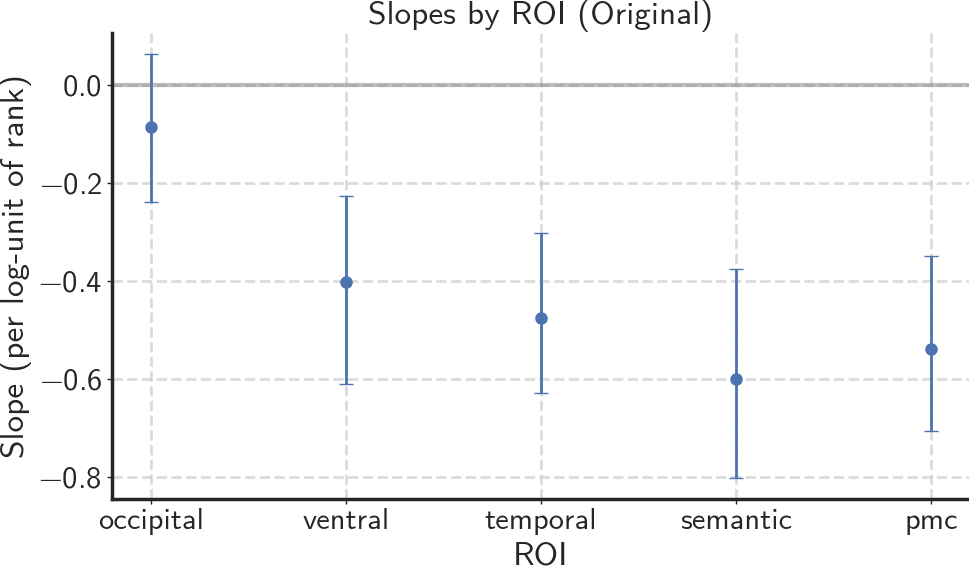

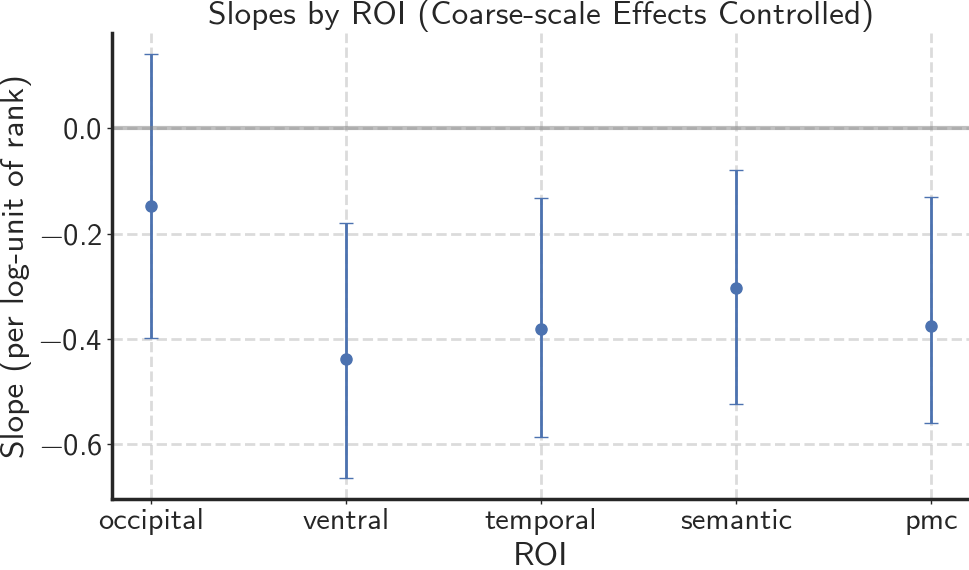

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def compute_roi_slopes(roi_bootstrap_correlations, rois, log_ranks=None, n_first_bins=5):
    """
    Compute slopes for each ROI across the first n rank bins.
    
    Parameters:
    -----------
    roi_bootstrap_correlations : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values.
        Each list item is an array of correlations for each rank bin.
    rois : list
        List of ROI names to analyze.
    log_ranks : array-like, optional
        Log of the rank values. If None, assumes rank 1 to n_first_bins.
    n_first_bins : int, default=5
        Number of first rank bins to use for slope calculation.
    
    Returns:
    --------
    slopes_df : pandas.DataFrame
        DataFrame containing the slopes, standard errors, and confidence intervals for each ROI.
    all_slopes : dict
        Dictionary with ROI names as keys and arrays of bootstrapped slopes as values.
    """
    if log_ranks is None:
        # Use log base 10 of ranks 1, 2, 3, 4, 5
        log_ranks = np.log10(np.arange(1, n_first_bins + 1))
    
    all_slopes = {}
    slopes = []
    slope_ses = []
    ci_lower = []
    ci_upper = []
    
    for roi in rois:
        boot_corrs = roi_bootstrap_correlations[roi]
        roi_slopes = []
        
        # For each bootstrap sample
        for boot_sample in boot_corrs:
            # Extract the correlations for the first n bins
            y = boot_sample[:n_first_bins]
            
            # Calculate slope using linear regression
            slope, _, _, _, _ = stats.linregress(log_ranks, y)
            roi_slopes.append(slope)
        
        # Store all bootstrapped slopes
        all_slopes[roi] = np.array(roi_slopes)
        
        # Calculate mean slope and standard error
        mean_slope = np.mean(roi_slopes)
        se_slope = np.std(roi_slopes, ddof=1)
        
        # Calculate 95% confidence interval from bootstrap distribution
        ci_95_lower = np.percentile(roi_slopes, 2.5)
        ci_95_upper = np.percentile(roi_slopes, 97.5)
        
        slopes.append(mean_slope)
        slope_ses.append(se_slope)
        ci_lower.append(ci_95_lower)
        ci_upper.append(ci_95_upper)
    
    # Create DataFrame with results
    slopes_df = pd.DataFrame({
        'roi': rois,
        'slope': slopes,
        'se': slope_ses,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })
    
    return slopes_df, all_slopes

def test_slope_differences(all_slopes, rois, alpha=0.05, correct_multiple_comparisons=True):
    """
    Test for significant differences in slopes between ROIs using permutation tests.
    
    Parameters:
    -----------
    all_slopes : dict
        Dictionary with ROI names as keys and arrays of bootstrapped slopes as values.
    rois : list
        List of ROI names to analyze.
    alpha : float, default=0.05
        Significance level for the tests.
    correct_multiple_comparisons : bool, default=True
        Whether to apply Bonferroni correction for multiple comparisons.
    
    Returns:
    --------
    pairwise_tests : pandas.DataFrame
        DataFrame containing p-values for each pairwise comparison.
    """
    n_comparisons = (len(rois) * (len(rois) - 1)) // 2
    n_permutations = 1000
    
    # Store results
    roi_pairs = []
    delta_slopes = []
    p_values = []
    
    # Perform pairwise comparisons
    for i, roi1 in enumerate(rois):
        for j, roi2 in enumerate(rois):
            if i >= j:  # Skip duplicate comparisons
                continue
                
            # Original difference in mean slopes
            slopes1 = all_slopes[roi1]
            slopes2 = all_slopes[roi2]
            observed_diff = np.mean(slopes1) - np.mean(slopes2)
            
            # Permutation test
            combined = np.concatenate([slopes1, slopes2])
            n1 = len(slopes1)
            n2 = len(slopes2)
            
            # Count how many permutation differences are as or more extreme
            count = 0
            for _ in range(n_permutations):
                np.random.shuffle(combined)
                perm_diff = np.mean(combined[:n1]) - np.mean(combined[n1:])
                
                # Two-sided test
                if abs(perm_diff) >= abs(observed_diff):
                    count += 1
            
            p_value = count / n_permutations
            
            roi_pairs.append(f"{roi1} vs {roi2}")
            delta_slopes.append(observed_diff)
            p_values.append(p_value)
    
    # Create DataFrame with results
    pairwise_tests = pd.DataFrame({
        'comparison': roi_pairs,
        'delta_slope': delta_slopes,
        'p_value': p_values,
        'significant': np.array(p_values) < (alpha / n_comparisons if correct_multiple_comparisons else alpha)
    })
    
    # Add corrected alpha if using Bonferroni
    if correct_multiple_comparisons:
        pairwise_tests['corrected_alpha'] = alpha / n_comparisons
    
    return pairwise_tests

def visualize_slopes(slopes_df, title="Slopes by ROI"):
    """
    Visualize the slopes and their confidence intervals for each ROI.
    
    Parameters:
    -----------
    slopes_df : pandas.DataFrame
        DataFrame containing the slopes and confidence intervals for each ROI.
    title : str, default="Slopes by ROI"
        Title for the plot.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the slopes and error bars
    ax.errorbar(
        slopes_df['roi'], 
        slopes_df['slope'], 
        yerr=[slopes_df['slope'] - slopes_df['ci_lower'], slopes_df['ci_upper'] - slopes_df['slope']],
        fmt='o', 
        capsize=5, 
        elinewidth=2, 
        markersize=8
    )
    
    ax.set_xlabel('ROI')
    ax.set_ylabel('Slope (per log-unit of rank)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    
    return fig

def run_analysis(roi_bootstrap_correlations_original, roi_bootstrap_correlations_controlled, rois):
    """
    Run the complete analysis for both original and controlled conditions.
    
    Parameters:
    -----------
    roi_bootstrap_correlations_original : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values for original condition.
    roi_bootstrap_correlations_controlled : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values for controlled condition.
    rois : list
        List of ROI names to analyze.
    
    Returns:
    --------
    results : dict
        Dictionary containing all analysis results.
    """
    # Log ranks for the first 5 bins (assuming rank 1, 2, 3, 4, 5)
    log_ranks = np.log10(np.arange(1, 6))
    
    # Compute slopes for original condition
    slopes_original, all_slopes_original = compute_roi_slopes(
        roi_bootstrap_correlations_original, 
        rois, 
        log_ranks=log_ranks,
        n_first_bins=5
    )
    
    # Compute slopes for controlled condition
    slopes_controlled, all_slopes_controlled = compute_roi_slopes(
        roi_bootstrap_correlations_controlled, 
        rois, 
        log_ranks=log_ranks,
        n_first_bins=5
    )
    
    # Test for differences between ROIs
    pairwise_tests_original = test_slope_differences(
        all_slopes_original, 
        rois, 
        alpha=0.05, 
        correct_multiple_comparisons=True
    )
    
    pairwise_tests_controlled = test_slope_differences(
        all_slopes_controlled, 
        rois, 
        alpha=0.05, 
        correct_multiple_comparisons=True
    )
    
    # Create visualizations
    fig_original = visualize_slopes(slopes_original, title="Slopes by ROI (Original)")
    fig_controlled = visualize_slopes(slopes_controlled, title="Slopes by ROI (Coarse-scale Effects Controlled)")
    
    # Combine results
    results = {
        'slopes_original': slopes_original,
        'slopes_controlled': slopes_controlled,
        'pairwise_tests_original': pairwise_tests_original,
        'pairwise_tests_controlled': pairwise_tests_controlled,
        'all_slopes_original': all_slopes_original,
        'all_slopes_controlled': all_slopes_controlled,
        'figures': {
            'original': fig_original,
            'controlled': fig_controlled
        }
    }
    
    return results

# Example usage:
# rois = ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial']
# results = run_analysis(roi_boot_corrs, roi_boot_corrs_controlled, rois)

def format_results_summary(results, rois):
    """
    Format a summary of the analysis results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing all analysis results.
    rois : list
        List of ROI names that were analyzed.
    
    Returns:
    --------
    summary : str
        Formatted summary of the results.
    """
    slopes_orig = results['slopes_original']
    slopes_ctrl = results['slopes_controlled']
    
    summary = "Analysis Summary\n"
    summary += "===============\n\n"
    
    # Slopes for each condition
    summary += "ROI Slopes (per log-unit of rank):\n"
    summary += "----------------------------\n"
    summary += "ROI             | Original Condition         | Controlled Condition\n"
    summary += "----------------|----------------------------|---------------------------\n"
    
    for roi in rois:
        orig_row = slopes_orig[slopes_orig['roi'] == roi].iloc[0]
        ctrl_row = slopes_ctrl[slopes_ctrl['roi'] == roi].iloc[0]
        
        orig_str = f"{orig_row['slope']:.2f} ± {orig_row['se']:.2f} (95% CI: {orig_row['ci_lower']:.2f}, {orig_row['ci_upper']:.2f})"
        ctrl_str = f"{ctrl_row['slope']:.2f} ± {ctrl_row['se']:.2f} (95% CI: {ctrl_row['ci_lower']:.2f}, {ctrl_row['ci_upper']:.2f})"
        
        summary += f"{roi.ljust(15)} | {orig_str.ljust(28)} | {ctrl_str}\n"
    
    # Significant differences between ROIs
    summary += "\n\nSignificant Differences (Bonferroni-corrected):\n"
    summary += "-------------------------------------------\n"
    
    # Original condition
    summary += "\nOriginal Condition:\n"
    sig_tests = results['pairwise_tests_original'][results['pairwise_tests_original']['significant']]
    
    if len(sig_tests) > 0:
        for _, row in sig_tests.iterrows():
            summary += f"- {row['comparison']}: Δslope = {row['delta_slope']:.2f}, p = {row['p_value']:.4f}\n"
    else:
        summary += "- No significant differences found.\n"
    
    # Controlled condition
    summary += "\nControlled Condition:\n"
    sig_tests = results['pairwise_tests_controlled'][results['pairwise_tests_controlled']['significant']]
    
    if len(sig_tests) > 0:
        for _, row in sig_tests.iterrows():
            summary += f"- {row['comparison']}: Δslope = {row['delta_slope']:.2f}, p = {row['p_value']:.4f}\n"
    else:
        summary += "- No significant differences found.\n"
    
    return summary

# Run the analysis
results = run_analysis(roi_boot_corrs, roi_boot_corrs_isc, rois)

# Generate and print a summary
summary = format_results_summary(results, rois)
print(summary)

# Access individual components
slopes_original = results['slopes_original']
significant_differences = results['pairwise_tests_original']
print(slopes_original)
print(significant_differences)

Analysis Summary

ROI Slopes (per log-unit of rank):
----------------------------
ROI             | Original Condition         | Controlled Condition
----------------|----------------------------|---------------------------
occipital       | -0.09 ± 0.08 (95% CI: -0.24, 0.06) | -0.15 ± 0.13 (95% CI: -0.40, 0.14)
ventral         | -0.40 ± 0.10 (95% CI: -0.61, -0.23) | -0.44 ± 0.13 (95% CI: -0.66, -0.18)
temporal        | -0.48 ± 0.08 (95% CI: -0.63, -0.30) | -0.38 ± 0.11 (95% CI: -0.59, -0.13)
semantic        | -0.60 ± 0.11 (95% CI: -0.80, -0.38) | -0.30 ± 0.12 (95% CI: -0.52, -0.08)
pmc             | -0.54 ± 0.09 (95% CI: -0.71, -0.35) | -0.37 ± 0.11 (95% CI: -0.56, -0.13)


Significant Differences (Bonferroni-corrected):
-------------------------------------------

Original Condition:
- occipital vs ventral: Δslope = 0.31, p = 0.0120
- occipital vs temporal: Δslope = 0.39, p = 0.0010
- occipital vs semantic: Δslope = 0.51, p = 0.0010
- occipital vs pmc: Δslope = 0.45, p = 0.0010

Cont

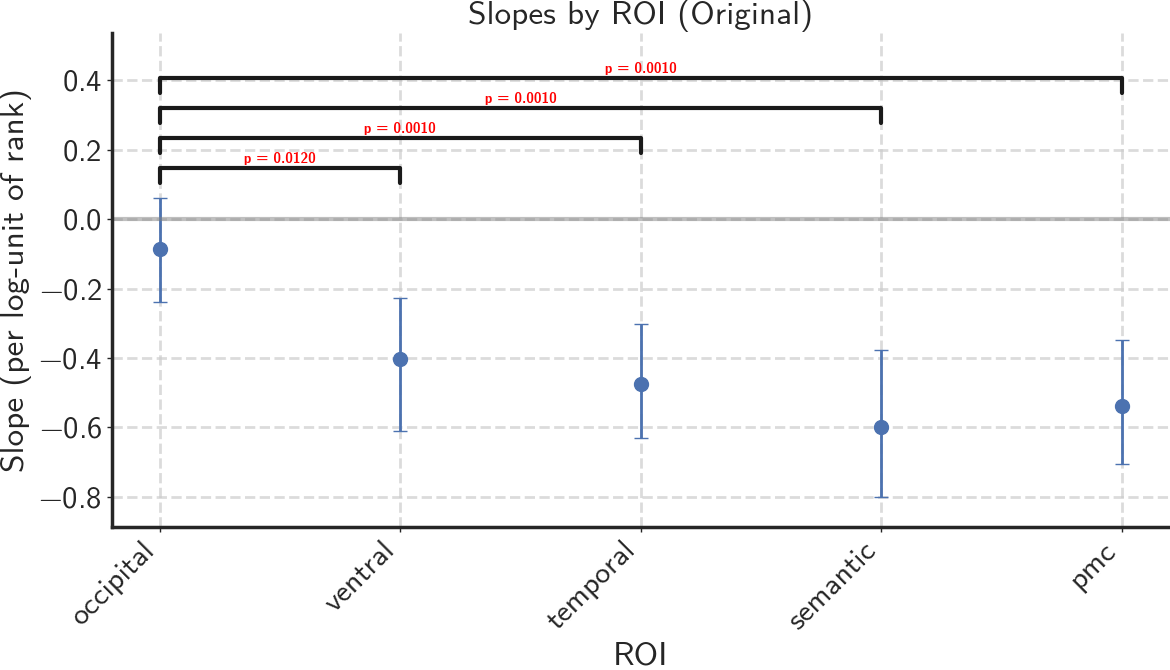

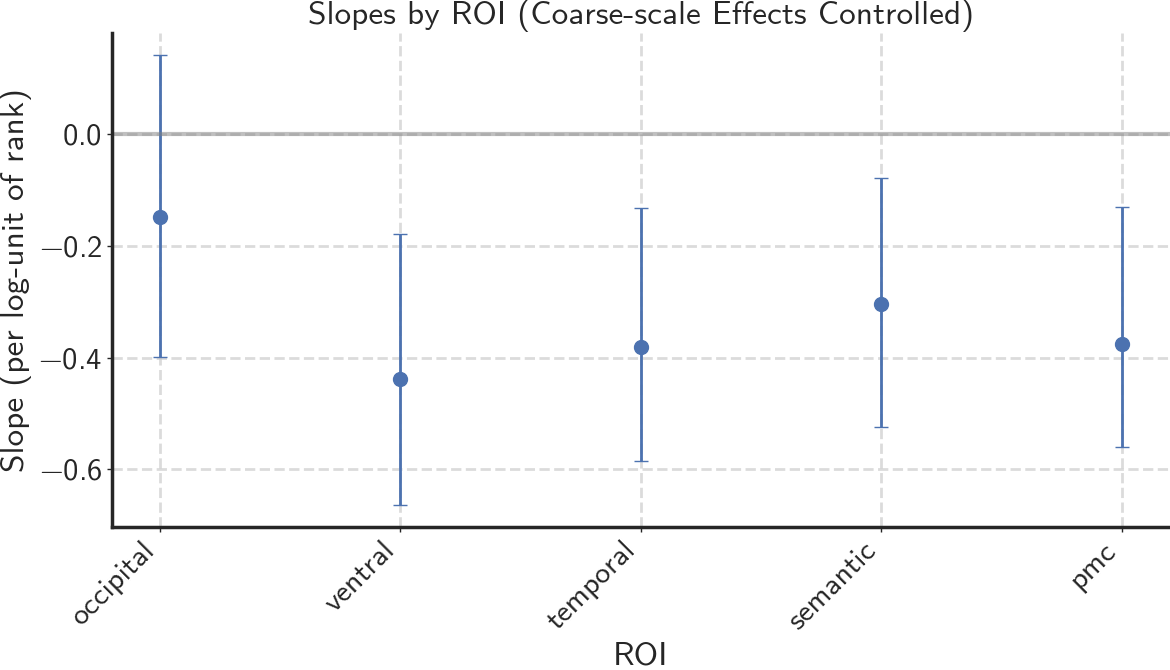

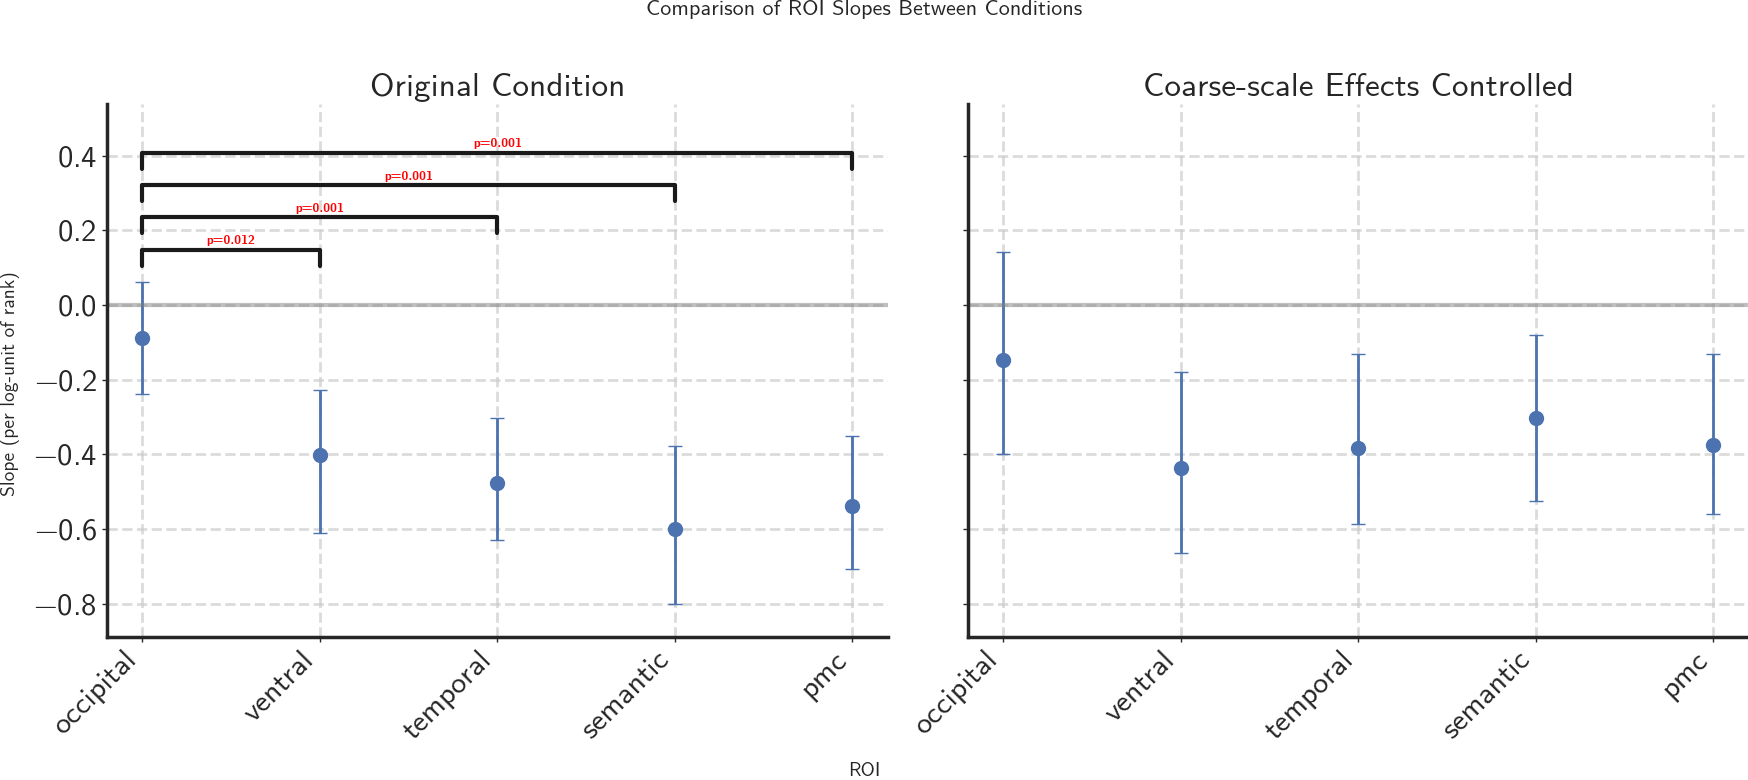

In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def compute_roi_slopes(roi_bootstrap_correlations, rois, log_ranks=None, n_first_bins=5):
    """
    Compute slopes for each ROI across the first n rank bins.
    
    Parameters:
    -----------
    roi_bootstrap_correlations : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values.
        Each list item is an array of correlations for each rank bin.
    rois : list
        List of ROI names to analyze.
    log_ranks : array-like, optional
        Log of the rank values. If None, assumes rank 1 to n_first_bins.
    n_first_bins : int, default=5
        Number of first rank bins to use for slope calculation.
    
    Returns:
    --------
    slopes_df : pandas.DataFrame
        DataFrame containing the slopes, standard errors, and confidence intervals for each ROI.
    all_slopes : dict
        Dictionary with ROI names as keys and arrays of bootstrapped slopes as values.
    """
    if log_ranks is None:
        # Use log base 10 of ranks 1, 2, 3, 4, 5
        log_ranks = np.log10(np.arange(1, n_first_bins + 1))
    
    all_slopes = {}
    slopes = []
    slope_ses = []
    ci_lower = []
    ci_upper = []
    
    for roi in rois:
        boot_corrs = roi_bootstrap_correlations[roi]
        roi_slopes = []
        
        # For each bootstrap sample
        for boot_sample in boot_corrs:
            # Extract the correlations for the first n bins
            y = boot_sample[:n_first_bins]
            
            # Calculate slope using linear regression
            slope, _, _, _, _ = stats.linregress(log_ranks, y)
            roi_slopes.append(slope)
        
        # Store all bootstrapped slopes
        all_slopes[roi] = np.array(roi_slopes)
        
        # Calculate mean slope and standard error
        mean_slope = np.mean(roi_slopes)
        se_slope = np.std(roi_slopes, ddof=1)
        
        # Calculate 95% confidence interval from bootstrap distribution
        ci_95_lower = np.percentile(roi_slopes, 2.5)
        ci_95_upper = np.percentile(roi_slopes, 97.5)
        
        slopes.append(mean_slope)
        slope_ses.append(se_slope)
        ci_lower.append(ci_95_lower)
        ci_upper.append(ci_95_upper)
    
    # Create DataFrame with results
    slopes_df = pd.DataFrame({
        'roi': rois,
        'slope': slopes,
        'se': slope_ses,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })
    
    return slopes_df, all_slopes

def test_slope_differences(all_slopes, rois, alpha=0.05, correct_multiple_comparisons=True):
    """
    Test for significant differences in slopes between ROIs using permutation tests.
    
    Parameters:
    -----------
    all_slopes : dict
        Dictionary with ROI names as keys and arrays of bootstrapped slopes as values.
    rois : list
        List of ROI names to analyze.
    alpha : float, default=0.05
        Significance level for the tests.
    correct_multiple_comparisons : bool, default=True
        Whether to apply Bonferroni correction for multiple comparisons.
    
    Returns:
    --------
    pairwise_tests : pandas.DataFrame
        DataFrame containing p-values for each pairwise comparison.
    """
    n_comparisons = (len(rois) * (len(rois) - 1)) // 2
    n_permutations = 1000
    
    # Store results
    roi_pairs = []
    delta_slopes = []
    p_values = []
    
    # Perform pairwise comparisons
    for i, roi1 in enumerate(rois):
        for j, roi2 in enumerate(rois):
            if i >= j:  # Skip duplicate comparisons
                continue
                
            # Original difference in mean slopes
            slopes1 = all_slopes[roi1]
            slopes2 = all_slopes[roi2]
            observed_diff = np.mean(slopes1) - np.mean(slopes2)
            
            # Permutation test
            combined = np.concatenate([slopes1, slopes2])
            n1 = len(slopes1)
            n2 = len(slopes2)
            
            # Count how many permutation differences are as or more extreme
            count = 0
            for _ in range(n_permutations):
                np.random.shuffle(combined)
                perm_diff = np.mean(combined[:n1]) - np.mean(combined[n1:])
                
                # Two-sided test
                if abs(perm_diff) >= abs(observed_diff):
                    count += 1
            
            p_value = count / n_permutations
            
            roi_pairs.append(f"{roi1} vs {roi2}")
            delta_slopes.append(observed_diff)
            p_values.append(p_value)
    
    # Create DataFrame with results
    pairwise_tests = pd.DataFrame({
        'comparison': roi_pairs,
        'delta_slope': delta_slopes,
        'p_value': p_values,
        'significant': np.array(p_values) < (alpha / n_comparisons if correct_multiple_comparisons else alpha)
    })
    
    # Add corrected alpha if using Bonferroni
    if correct_multiple_comparisons:
        pairwise_tests['corrected_alpha'] = alpha / n_comparisons
    
    return pairwise_tests

def test_slope_differences_bootstrap(all_slopes, rois, alpha=0.05, correct_multiple_comparisons=True):
    """
    Test for significant differences in slopes between ROIs using bootstrap CIs.
    """
    n_comparisons = (len(rois) * (len(rois) - 1)) // 2
    
    # Store results
    roi_pairs = []
    delta_slopes = []
    ci_lower = []
    ci_upper = []
    p_values = []
    
    # Calculate adjusted alpha if using Bonferroni
    adjusted_alpha = alpha / n_comparisons if correct_multiple_comparisons else alpha
    
    # For each pair of ROIs
    for i, roi1 in enumerate(rois):
        for j, roi2 in enumerate(rois):
            if i >= j:  # Skip duplicate comparisons
                continue
                
            # Get bootstrap samples of slopes
            slopes1 = all_slopes[roi1]
            slopes2 = all_slopes[roi2]
            
            # Calculate the difference for each bootstrap sample
            diff_samples = slopes1 - slopes2
            
            # Calculate mean difference
            mean_diff = np.mean(diff_samples)
            
            # Calculate bootstrap confidence interval
            lower, upper = np.percentile(diff_samples, [100 * adjusted_alpha / 2, 100 * (1 - adjusted_alpha / 2)])
            
            # Check if the CI includes zero
            significant = (lower > 0) or (upper < 0)
            
            # Calculate bootstrap p-value (two-sided)
            # Proportion of bootstrap samples that are on the opposite side of zero from the mean difference
            if mean_diff > 0:
                p_value = np.mean(diff_samples <= 0) * 2  # two-sided
            else:
                p_value = np.mean(diff_samples >= 0) * 2  # two-sided
            
            # Ensure p-value is not smaller than 1/n_bootstraps
            p_value = max(p_value, 1.0 / len(diff_samples))
            
            roi_pairs.append(f"{roi1} vs {roi2}")
            delta_slopes.append(mean_diff)
            ci_lower.append(lower)
            ci_upper.append(upper)
            p_values.append(p_value)
    
    # Create DataFrame with results
    pairwise_tests = pd.DataFrame({
        'comparison': roi_pairs,
        'delta_slope': delta_slopes,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_values,
        'significant': [p <= alpha for p in p_values]
    })
    
    return pairwise_tests

def visualize_slopes(slopes_df, pairwise_tests=None, title="Slopes by ROI"):
    """
    Visualize the slopes and their confidence intervals for each ROI.
    Optionally mark significant differences between ROIs.
    
    Parameters:
    -----------
    slopes_df : pandas.DataFrame
        DataFrame containing the slopes and confidence intervals for each ROI.
    pairwise_tests : pandas.DataFrame, optional
        DataFrame containing the results of pairwise tests. If provided,
        significant differences will be marked on the plot.
    title : str, default="Slopes by ROI"
        Title for the plot.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    rois = slopes_df['roi'].tolist()
    x_positions = np.arange(len(rois))
    
    # Plot the slopes and error bars
    ax.errorbar(
        x_positions, 
        slopes_df['slope'], 
        yerr=[slopes_df['slope'] - slopes_df['ci_lower'], slopes_df['ci_upper'] - slopes_df['slope']],
        fmt='o', 
        capsize=5, 
        elinewidth=2, 
        markersize=10,
        label='Slope with 95% CI'
    )
    
    # Add significant difference markers if provided
    if pairwise_tests is not None:
        significant_tests = pairwise_tests[pairwise_tests['significant']]
        
        # Set the height for the annotation bars
        y_max = slopes_df['ci_upper'].max()
        y_min = slopes_df['ci_lower'].min()
        y_range = y_max - y_min
        bar_heights = []
        
        # Draw significant comparison brackets
        for i, (_, row) in enumerate(significant_tests.iterrows()):
            # Parse the comparison to get the two ROIs
            roi1, roi2 = row['comparison'].split(' vs ')
            
            # Get their positions
            pos1 = rois.index(roi1)
            pos2 = rois.index(roi2)
            
            # Set the height for this bracket (increase height for overlapping brackets)
            bar_height = y_max + (i + 1) * 0.1 * y_range
            bar_heights.append(bar_height)
            
            # Draw the bracket
            x1, x2 = x_positions[pos1], x_positions[pos2]
            ax.plot([x1, x1, x2, x2], [bar_height - 0.05 * y_range, bar_height, bar_height, bar_height - 0.05 * y_range], 'k-')
            
            # Add p-value text
            p_text = f'p = {row["p_value"]:.4f}'
            ax.text((x1 + x2) / 2, bar_height + 0.01 * y_range, p_text, 
                    ha='center', va='bottom', color='red', fontweight='bold')
        
        # Update y limits to accommodate the brackets
        if bar_heights:
            ax.set_ylim(bottom=y_min - 0.1 * y_range, top=max(bar_heights) + 0.15 * y_range)
    
    # Set x-ticks to ROI names
    ax.set_xticks(x_positions)
    ax.set_xticklabels(rois, rotation=45, ha='right')
    
    ax.set_xlabel('ROI')
    ax.set_ylabel('Slope (per log-unit of rank)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    
    return fig

def run_analysis(roi_bootstrap_correlations_original, roi_bootstrap_correlations_controlled, rois):
    """
    Run the complete analysis for both original and controlled conditions.
    
    Parameters:
    -----------
    roi_bootstrap_correlations_original : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values for original condition.
    roi_bootstrap_correlations_controlled : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations as values for controlled condition.
    rois : list
        List of ROI names to analyze.
    
    Returns:
    --------
    results : dict
        Dictionary containing all analysis results.
    """
    # Log ranks for the first 5 bins (assuming rank 1, 2, 3, 4, 5)
    log_ranks = np.log10(np.arange(1, 6))
    
    # Compute slopes for original condition
    slopes_original, all_slopes_original = compute_roi_slopes(
        roi_bootstrap_correlations_original, 
        rois, 
        log_ranks=log_ranks,
        n_first_bins=5
    )
    
    # Compute slopes for controlled condition
    slopes_controlled, all_slopes_controlled = compute_roi_slopes(
        roi_bootstrap_correlations_controlled, 
        rois, 
        log_ranks=log_ranks,
        n_first_bins=5
    )
    
    # # Test for differences between ROIs
    # pairwise_tests_original = test_slope_differences(
    #     all_slopes_original, 
    #     rois, 
    #     alpha=0.05, 
    #     correct_multiple_comparisons=True
    # )
    
    # pairwise_tests_controlled = test_slope_differences(
    #     all_slopes_controlled, 
    #     rois, 
    #     alpha=0.05, 
    #     correct_multiple_comparisons=True
    # )
        
    # Test for differences between ROIs using bootstrap method
    pairwise_tests_original = test_slope_differences_bootstrap(
        all_slopes_original, 
        rois, 
        alpha=0.05, 
        correct_multiple_comparisons=True
    )
    
    pairwise_tests_controlled = test_slope_differences_bootstrap(
        all_slopes_controlled, 
        rois, 
        alpha=0.05, 
        correct_multiple_comparisons=True
    )
    
    
    # Create visualizations with significance markers
    fig_original = visualize_slopes(
        slopes_original, 
        pairwise_tests=pairwise_tests_original,
        title="Slopes by ROI (Original)"
    )
    
    fig_controlled = visualize_slopes(
        slopes_controlled, 
        pairwise_tests=pairwise_tests_controlled,
        title="Slopes by ROI (Coarse-scale Effects Controlled)"
    )
    
    # Combine results
    results = {
        'slopes_original': slopes_original,
        'slopes_controlled': slopes_controlled,
        'pairwise_tests_original': pairwise_tests_original,
        'pairwise_tests_controlled': pairwise_tests_controlled,
        'all_slopes_original': all_slopes_original,
        'all_slopes_controlled': all_slopes_controlled,
        'figures': {
            'original': fig_original,
            'controlled': fig_controlled
        }
    }


    return results


# Example usage:
# rois = ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial']
# results = run_analysis(roi_boot_corrs, roi_boot_corrs_controlled, rois)
#
# To create a combined plot showing both conditions side by side:
def create_combined_plot(results, rois):
    """
    Create a combined plot showing slopes for both original and controlled conditions.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing analysis results from run_analysis.
    rois : list
        List of ROI names that were analyzed.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the combined plot.
    """
    slopes_orig = results['slopes_original']
    slopes_ctrl = results['slopes_controlled']
    pairwise_tests_orig = results['pairwise_tests_original']
    pairwise_tests_ctrl = results['pairwise_tests_controlled']
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    
    # Helper function to plot on a specific axis
    def plot_on_axis(ax, slopes_df, pairwise_tests, title):
        rois = slopes_df['roi'].tolist()
        x_positions = np.arange(len(rois))
        
        # Plot slopes and error bars
        ax.errorbar(
            x_positions, 
            slopes_df['slope'], 
            yerr=[slopes_df['slope'] - slopes_df['ci_lower'], slopes_df['ci_upper'] - slopes_df['slope']],
            fmt='o', 
            capsize=5, 
            elinewidth=2, 
            markersize=10
        )
        
        # Add significant difference markers
        significant_tests = pairwise_tests[pairwise_tests['significant']]
        
        # Set the height for the annotation bars
        y_max = slopes_df['ci_upper'].max()
        y_min = slopes_df['ci_lower'].min()
        y_range = y_max - y_min
        bar_heights = []
        
        # Draw significant comparison brackets
        for i, (_, row) in enumerate(significant_tests.iterrows()):
            # Parse the comparison
            roi1, roi2 = row['comparison'].split(' vs ')
            
            # Get positions
            pos1 = rois.index(roi1)
            pos2 = rois.index(roi2)
            
            # Set height for this bracket
            bar_height = y_max + (i + 1) * 0.1 * y_range
            bar_heights.append(bar_height)
            
            # Draw the bracket
            x1, x2 = x_positions[pos1], x_positions[pos2]
            ax.plot([x1, x1, x2, x2], [bar_height - 0.05 * y_range, bar_height, bar_height, bar_height - 0.05 * y_range], 'k-')
            
            # Add p-value text
            p_text = f'p={row["p_value"]:.3f}'
            ax.text((x1 + x2) / 2, bar_height + 0.01 * y_range, p_text, 
                    ha='center', va='bottom', color='red', fontweight='bold', fontsize=9)
        
        # Update y limits
        if bar_heights:
            ax.set_ylim(bottom=y_min - 0.1 * y_range, top=max(bar_heights) + 0.15 * y_range)
        
        # Set x-ticks
        ax.set_xticks(x_positions)
        ax.set_xticklabels(rois, rotation=45, ha='right')
        
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Plot on both axes
    plot_on_axis(ax1, slopes_orig, pairwise_tests_orig, "Original Condition")
    plot_on_axis(ax2, slopes_ctrl, pairwise_tests_ctrl, "Coarse-scale Effects Controlled")
    
    # Add common labels
    fig.text(0.5, 0.01, 'ROI', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Slope (per log-unit of rank)', va='center', rotation='vertical', fontsize=14)
    fig.suptitle('Comparison of ROI Slopes Between Conditions', fontsize=16)
    
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    
    return fig

def format_results_summary(results, rois):
    """
    Format a summary of the analysis results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing all analysis results.
    rois : list
        List of ROI names that were analyzed.
    
    Returns:
    --------
    summary : str
        Formatted summary of the results.
    """
    slopes_orig = results['slopes_original']
    slopes_ctrl = results['slopes_controlled']
    
    summary = "Analysis Summary\n"
    summary += "===============\n\n"
    
    # Slopes for each condition
    summary += "ROI Slopes (per log-unit of rank):\n"
    summary += "----------------------------\n"
    summary += "ROI             | Original Condition         | Controlled Condition\n"
    summary += "----------------|----------------------------|---------------------------\n"
    
    for roi in rois:
        orig_row = slopes_orig[slopes_orig['roi'] == roi].iloc[0]
        ctrl_row = slopes_ctrl[slopes_ctrl['roi'] == roi].iloc[0]
        
        orig_str = f"{orig_row['slope']:.2f} ± {orig_row['se']:.2f} (95% CI: {orig_row['ci_lower']:.2f}, {orig_row['ci_upper']:.2f})"
        ctrl_str = f"{ctrl_row['slope']:.2f} ± {ctrl_row['se']:.2f} (95% CI: {ctrl_row['ci_lower']:.2f}, {ctrl_row['ci_upper']:.2f})"
        
        summary += f"{roi.ljust(15)} | {orig_str.ljust(28)} | {ctrl_str}\n"
    
    # Significant differences between ROIs
    summary += "\n\nSignificant Differences (Bonferroni-corrected):\n"
    summary += "-------------------------------------------\n"
    
    # Original condition
    summary += "\nOriginal Condition:\n"
    sig_tests = results['pairwise_tests_original'][results['pairwise_tests_original']['significant']]
    
    if len(sig_tests) > 0:
        for _, row in sig_tests.iterrows():
            summary += f"- {row['comparison']}: Δslope = {row['delta_slope']:.2f}, p = {row['p_value']:.4f}\n"
    else:
        summary += "- No significant differences found.\n"
    
    # Controlled condition
    summary += "\nControlled Condition:\n"
    sig_tests = results['pairwise_tests_controlled'][results['pairwise_tests_controlled']['significant']]
    
    if len(sig_tests) > 0:
        for _, row in sig_tests.iterrows():
            summary += f"- {row['comparison']}: Δslope = {row['delta_slope']:.2f}, p = {row['p_value']:.4f}\n"
    else:
        summary += "- No significant differences found.\n"
    
    return summary


# Run the analysis
results = run_analysis(roi_boot_corrs, roi_boot_corrs_isc, rois)

# Generate the combined plot
combined_fig = create_combined_plot(results, rois)
#combined_fig.savefig('roi_slopes_comparison.png', dpi=300, bbox_inches='tight')

# Print the results summary
summary = format_results_summary(results, rois)
print(summary)

mean reduction in r = 0.09 ± 0.00 for ranks 1-10 across all regions; paired t-test, t(4) = 7.56, p = 0.0016

ROI-specific reductions:
         roi  mean_reduction        se  p_value  significant
0  occipital        0.124734  0.001436    0.006         True
1    ventral        0.084291  0.001352    0.048         True
2   temporal        0.084360  0.001279    0.042         True
3   semantic        0.086399  0.001133    0.022         True
4        pmc        0.052626  0.001788    0.356        False


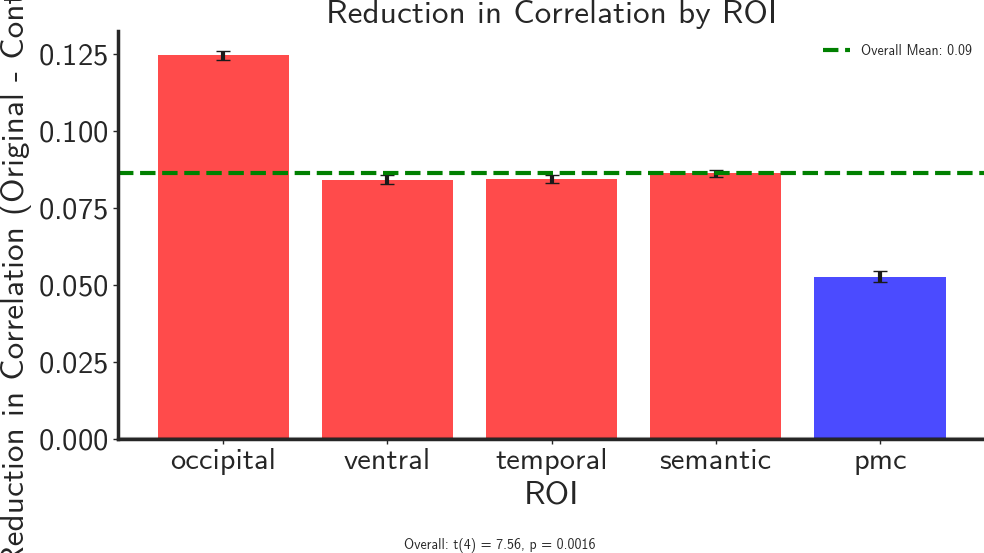

In [14]:
def compute_reduction_stats(roi_boot_corrs_original, roi_boot_corrs_controlled, rois, rank_range=(0, 10)):
    """
    Compute the reduction in correlation from original to coarse-effect controlled condition.
    
    Parameters:
    -----------
    roi_boot_corrs_original : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations for original condition.
    roi_boot_corrs_controlled : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations for controlled condition.
    rois : list
        List of ROI names to analyze.
    rank_range : tuple, default=(0, 10)
        Range of ranks to include in the analysis (inclusive start, exclusive end).
    
    Returns:
    --------
    dict
        Dictionary containing reduction statistics both overall and per ROI.
    """
    start_rank, end_rank = rank_range
    
    # Initialize containers for results
    all_reductions = []
    roi_reductions = {}
    
    # Compute reductions for each ROI
    for roi in rois:
        roi_reductions[roi] = []
        
        # For each bootstrap sample
        n_bootstraps = len(roi_boot_corrs_original[roi])
        for i in range(n_bootstraps):
            # Get correlations for the specified rank range
            orig_corrs = roi_boot_corrs_original[roi][i][start_rank:end_rank]
            ctrl_corrs = roi_boot_corrs_controlled[roi][i][start_rank:end_rank]
            
            # Compute mean reduction for this bootstrap sample
            reduction = np.mean(orig_corrs - ctrl_corrs)
            roi_reductions[roi].append(reduction)
            all_reductions.append(reduction)
    
    # Convert to arrays
    all_reductions = np.array(all_reductions)
    for roi in rois:
        roi_reductions[roi] = np.array(roi_reductions[roi])
    
    # Compute overall statistics
    overall_mean = np.mean(all_reductions)
    overall_se = np.std(all_reductions, ddof=1) / np.sqrt(len(all_reductions))
    
    # Compute per-ROI statistics
    roi_stats = {}
    for roi in rois:
        reductions = roi_reductions[roi]
        roi_stats[roi] = {
            'mean': np.mean(reductions),
            'se': np.std(reductions, ddof=1) / np.sqrt(len(reductions)),
            'ci_lower': np.percentile(reductions, 2.5),
            'ci_upper': np.percentile(reductions, 97.5)
        }
    
    # Perform paired t-test across ROIs
    roi_means = [np.mean(roi_reductions[roi]) for roi in rois]
    t_stat, p_value = stats.ttest_1samp(roi_means, 0)
    
    results = {
        'overall': {
            'mean': overall_mean,
            'se': overall_se,
            'statement': f"mean reduction in r = {overall_mean:.2f} ± {overall_se:.2f} for ranks {start_rank+1}-{end_rank} across all regions; paired t-test, t({len(rois)-1}) = {t_stat:.2f}, p = {p_value:.4f}"
        },
        'roi_specific': roi_stats,
        't_test': {
            't_stat': t_stat,
            'p_value': p_value,
            'df': len(rois) - 1
        }
    }
    
    return results

def test_roi_specific_reductions(roi_boot_corrs_original, roi_boot_corrs_controlled, rois, rank_range=(0, 10)):
    """
    Test the significance of reduction in correlation for each ROI individually.
    
    Parameters:
    -----------
    roi_boot_corrs_original : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations for original condition.
    roi_boot_corrs_controlled : dict
        Dictionary with ROI names as keys and lists of bootstrapped correlations for controlled condition.
    rois : list
        List of ROI names to analyze.
    rank_range : tuple, default=(0, 10)
        Range of ranks to include in the analysis (inclusive start, exclusive end).
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing test results for each ROI.
    """
    start_rank, end_rank = rank_range
    
    results = []
    
    for roi in rois:
        # Compute differences for each bootstrap sample
        differences = []
        n_bootstraps = len(roi_boot_corrs_original[roi])
        
        for i in range(n_bootstraps):
            orig_corrs = roi_boot_corrs_original[roi][i][start_rank:end_rank]
            ctrl_corrs = roi_boot_corrs_controlled[roi][i][start_rank:end_rank]
            
            # Mean difference for this bootstrap sample
            diff = np.mean(orig_corrs - ctrl_corrs)
            differences.append(diff)
        
        # Calculate bootstrap statistics
        mean_diff = np.mean(differences)
        se_diff = np.std(differences, ddof=1) / np.sqrt(len(differences))
        ci_lower = np.percentile(differences, 2.5)
        ci_upper = np.percentile(differences, 97.5)
        
        # Calculate p-value (proportion of bootstrap samples <= 0)
        p_value = np.mean(np.array(differences) <= 0)
        # Make it two-sided
        p_value = min(p_value, 1 - p_value) * 2
        
        results.append({
            'roi': roi,
            'mean_reduction': mean_diff,
            'se': se_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'p_value': p_value,
            'significant': p_value < 0.05
        })
    
    return pd.DataFrame(results)

def plot_reductions(reduction_results, roi_tests, title="Reduction in Correlation by ROI"):
    """
    Plot the reduction in correlation for each ROI with significance indicators.
    
    Parameters:
    -----------
    reduction_results : dict
        Results from compute_reduction_stats.
    roi_tests : pandas.DataFrame
        Results from test_roi_specific_reductions.
    title : str, default="Reduction in Correlation by ROI"
        Title for the plot.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data
    rois = roi_tests['roi'].tolist()
    reductions = roi_tests['mean_reduction'].values
    errors = roi_tests['se'].values
    significant = roi_tests['significant'].values
    
    # Set color based on significance
    colors = ['red' if sig else 'blue' for sig in significant]
    
    # Create bar plot
    bars = ax.bar(rois, reductions, yerr=errors, capsize=5, color=colors, alpha=0.7)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add overall mean
    overall_mean = reduction_results['overall']['mean']
    ax.axhline(y=overall_mean, color='green', linestyle='--', 
               label=f"Overall Mean: {overall_mean:.2f}")
    
    # Add labels and title
    ax.set_xlabel('ROI')
    ax.set_ylabel('Reduction in Correlation (Original - Controlled)')
    ax.set_title(title)
    ax.legend()
    
    # Add text for overall t-test
    t_stat = reduction_results['t_test']['t_stat']
    p_value = reduction_results['t_test']['p_value']
    df = reduction_results['t_test']['df']
    stats_text = f"Overall: t({df}) = {t_stat:.2f}, p = {p_value:.4f}"
    ax.text(0.5, 0.01, stats_text, transform=fig.transFigure, 
            ha='center', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig


# Compute reduction statistics for ranks 1-10
reduction_results = compute_reduction_stats(
    roi_boot_corrs, 
    roi_boot_corrs_isc, 
    rois, 
    rank_range=(0, 10)  # Ranks 1-10 (0-indexed)
)

# Test significance for each ROI individually
roi_tests = test_roi_specific_reductions(
    roi_boot_corrs, 
    roi_boot_corrs_isc, 
    rois, 
    rank_range=(0, 10)
)

# Print the overall statement
print(reduction_results['overall']['statement'])

# Print ROI-specific results
print("\nROI-specific reductions:")
print(roi_tests[['roi', 'mean_reduction', 'se', 'p_value', 'significant']])

# Create a visualization
reduction_plot = plot_reductions(reduction_results, roi_tests)

In [10]:
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}

alpha = 0.05 / len(unique_bins) # Bonferroni correction
def bootstrap_ci(bootstrap_samples, alpha=0.05):
    lower = np.percentile(bootstrap_samples, alpha/2 * 100)
    upper = np.percentile(bootstrap_samples, (1-alpha/2) * 100)
    return lower, upper

for n_roi, roi in enumerate(rois):
    print(roi)
    for n_bin, bin in enumerate(unique_bins):
        bootstrapped_correlations = roi_boot_corrs_isc[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        print(bin, lower)
        if lower > 0:
            significance_isc[roi].append(bin)
    
        bootstrapped_correlations = roi_boot_corrs[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        print(bin, lower)
        if lower > 0:
            significance[roi].append(bin)

occipital
1.5199110829529339 0.42133022544577753
1.5199110829529339 0.6062066479562199
3.5111917342151306 0.5640586151691107
3.5111917342151306 0.7451113879112207
8.11130830789687 0.449986636746734
8.11130830789687 0.6009026541763186
18.73817422860384 0.3714589104379707
18.73817422860384 0.5536618675993509
43.2876128108306 0.3588645102497092
43.2876128108306 0.630158515349639
100.00000000000004 0.27635230791800325
100.00000000000004 0.3985501877333755
231.012970008316 0.10069287032240164
231.012970008316 0.16085744156821236
533.6699231206308 0.0028756887986400225
533.6699231206308 0.018744153233835104
1232.8467394420663 -0.05616820756179439
1232.8467394420663 -0.05037032329501946
ventral
1.5199110829529339 0.4668483920852762
1.5199110829529339 0.6506763035611757
3.5111917342151306 0.4322379535549317
3.5111917342151306 0.519327283796159
8.11130830789687 0.36772917381017983
8.11130830789687 0.503270847143725
18.73817422860384 0.18801638420194905
18.73817422860384 0.3272631463614655
43.28

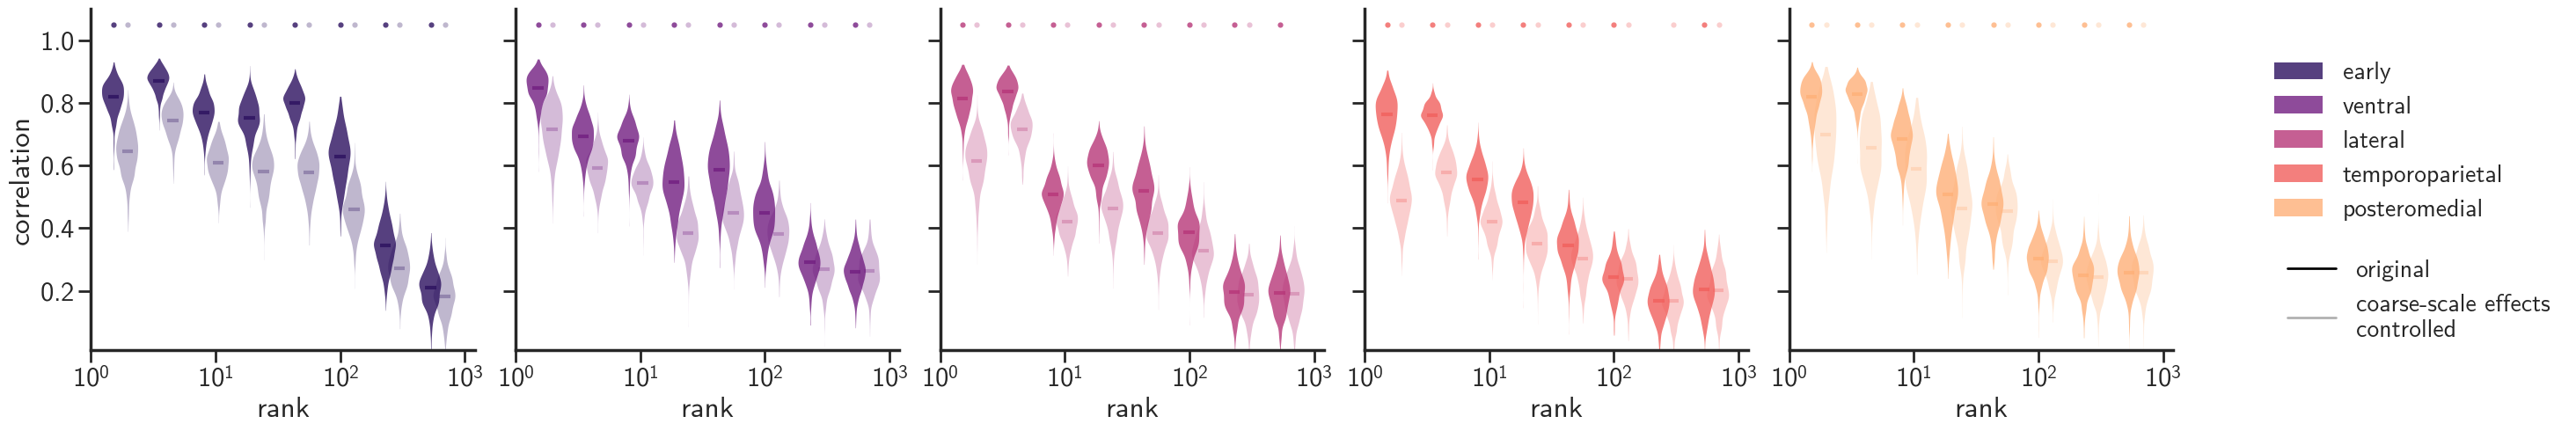

In [21]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

alpha = 0.05
figure, axes = plt.subplots(1, 5, figsize=(25, 5))
plt.rcParams.update({
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'figure.constrained_layout.use': True,
    'figure.constrained_layout.w_pad': 0.05,
    'figure.constrained_layout.h_pad': 0.05,
})
# set color map
idm_roi_colors = sns.color_palette("magma", n_colors=len(rois))

for n_roi, roi in enumerate(rois):
    for n_bin, bin in enumerate(unique_bins[:-1]):
        # Get bootstrap samples for both conditions
        samples_isc = np.array([sp[n_bin] for sp in roi_boot_corrs_isc[roi]])
        samples = np.array([sp[n_bin] for sp in roi_boot_corrs[roi]])
        
        # Create positions for the violin plots
        pos = bin if bin > 1 else 1  # Ensure we don't have 0 position for log scale
        
        # Width needs to scale linearly with x to maintain constant visual width in log space
        # Base width is 0.2 (20% of the value)
        width = pos * 0.4  
        
        # Create violin plots with adjusted widths
        v1 = axes[n_roi].violinplot(samples_isc, [pos * 1.3], points=100,
                                  widths=[pos * 1.3 * 0.4],  # Scale width with shifted position
                                  showmeans=True, showextrema=False)
        v2 = axes[n_roi].violinplot(samples, [pos], points=100,
                                  widths=[width],
                                  showmeans=True, showextrema=False)
        
        # Style the violin plots
        # ISC-controlled (solid)
        v1['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v1['bodies'][0].set_alpha(0.3)
        v1['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v1['cmeans'].set_alpha(0.3)
        #v1['cmins'].set_color(idm_roi_colors[rois.index(roi)])
        #v1['cmaxes'].set_color(idm_roi_colors[rois.index(roi)])
        #v1['cbars'].set_color(idm_roi_colors[rois.index(roi)])
        
        # Original correlations (transparent)
        v2['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v2['bodies'][0].set_alpha(0.8)
        v2['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v2['cmeans'].set_alpha(0.8)
        #v2['cmins'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cmins'].set_alpha(0.3)
        #v2['cmaxes'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cmaxes'].set_alpha(0.3)
        #v2['cbars'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cbars'].set_alpha(0.3)
        
        #Add significance testing if needed
        if bin in significance_isc[roi]:
            axes[n_roi].scatter(pos * 1.3, 1.05, color=idm_roi_colors[n_roi], alpha=0.3, s=20)
        if bin in significance[roi]:
            axes[n_roi].scatter(pos, 1.05, color=idm_roi_colors[n_roi], alpha=0.8, s=20)
          
    
    # Set scales and limits
    axes[n_roi].set_xscale('log')
    axes[n_roi].set_xlabel('rank')
    axes[n_roi].set_xlim(1, 1200)
    axes[n_roi].set_ylim(10e-3, 1.10)
    axes[n_roi].tick_params(axis='both', which='major', length=10, width=2)

    # Set labels and ticks
    if n_roi == 0:
        axes[n_roi].set_ylabel("correlation")
    else:
        axes[n_roi].set_yticklabels([])
        axes[n_roi].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

# Add legend (original - solid, coarse-scale effects controlled - transparent) on the right side
legend_elements = [Line2D([0], [0], color='black', lw=2, label='original'),
                   Line2D([0], [0], color='black', lw=2, alpha=0.3, label='coarse-scale effects \ncontrolled')]
figure.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.175, 0.45), fontsize=20)
# Add ROI legend
roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
figure.legend(roi_patches, ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial'], 
            bbox_to_anchor=(1.15, 0.9),
            loc='upper right', 
            frameon=False, 
            fontsize=20)

# Add titles and labels
#figure.text(0.5, 0, 'rank', ha='center', fontsize=24)
# figure.text(0.13, 0.95, 'early', ha='center', va='bottom', fontsize=24)
# figure.text(0.33, 0.95, 'ventral', ha='center', va='bottom', fontsize=24)
# figure.text(0.52, 0.95, 'lateral', ha='center', va='bottom', fontsize=24)
# figure.text(0.72, 0.95, 'temporoparietal', ha='center', va='bottom', fontsize=24)
# figure.text(0.92, 0.95, 'posteromedial', ha='center', va='bottom', fontsize=24)

#plt.show()
# plt.savefig('figure2_violin_perm_original.svg', format='svg', dpi=300, transparent=True)
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure2_violin_bs_sig_all.svg', format='svg', dpi=300, transparent=True)
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure2_violin_bs_sig_all.pdf', format='pdf', dpi=300, transparent=True)

- Compute permuted IDM correlations

In [ ]:
def permute_idm_series(args, n_permutations=1000):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    permuted_series = {movie: [] for movie in movies}
    if args.isc:
        file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_permuted_fp_isc_{str(n_permutations)}.pkl"
    else:
        file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_permuted_fp_{str(n_permutations)}.pkl"
    if os.path.exists(file):
        permuted_series = pickle.load(open(file, "rb"))
    else:
        for p in tqdm(range(n_permutations)):
            with h5py.File(h5_data_path, 'r') as h5f:
                for movie in movies:
                    all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
                    perm_i = np.random.permutation(subjects)
                    perm_j = np.random.permutation(subjects)
                    for i, i_subject in enumerate(perm_i):
                        for j, j_subject in enumerate(perm_j):
                            if i_subject != j_subject:
                                try:
                                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                                except:
                                    spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:min_length]
                                for n_bin, bin_id in enumerate(unique_bins):
                                    try:
                                        all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                                        all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                                    except Exception as e:
                                        continue
                    permuted_series[movie].append(np.moveaxis(all_spectra, -1, 0))
        with open(file, "wb") as f:
            pickle.dump(permuted_series, f)
            
    return permuted_series

for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )

    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None       

    permuted_series = permute_idm_series(args)

    for perm_idx in range(1000):
        permuted_idm1 = np.nanmean([permuted_series[movie][perm_idx] for movie in config.movies[::2]], axis=0)
        permuted_idm2 = np.nanmean([permuted_series[movie][perm_idx] for movie in config.movies[1::2]], axis=0)

        if args.isc:
            corr = np.zeros((len(unique_bins)))
            for n_bin in range(len(unique_bins)):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_upper_triangle(permuted_idm1[n_bin]),
                    get_upper_triangle(permuted_idm2[n_bin]),
                    get_upper_triangle(even_motion1),
                    get_upper_triangle(odd_motion1))
                _, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_motion2),
                    get_upper_triangle(odd_motion2))
                r, _, _ = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_anat),
                    get_upper_triangle(odd_anat))
                corr[n_bin] = r
            roi_perm_corrs_isc[roi].append(corr)
        else:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_upper_triangle(permuted_idm1[n_bin]),
                    get_upper_triangle(permuted_idm2[n_bin]),
                    get_upper_triangle(even_motion1),
                    get_upper_triangle(odd_motion1))
                r, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_motion2),
                    get_upper_triangle(odd_motion2))
                #print(r)
                corr[n_bin] = r
            roi_perm_corrs[roi].append(corr)

        diagonals = np.zeros((len(unique_bins), len(unique_bins)))
        for i, bin in enumerate(unique_bins):
            permuted_idm1_tri = permuted_idm1[i][np.triu_indices(permuted_idm1[i].shape[1], k=1)]
            for j, bin in enumerate(unique_bins):
                diagonals[i, j] = np.corrcoef(permuted_idm1_tri, permuted_idm2[j][np.triu_indices(permuted_idm2[j].shape[1], k=1)])[0, 1]
        if args.isc:
            roi_perm_split_corrs_isc[roi].append(diagonals)
        else:
            roi_perm_split_corrs[roi].append(diagonals)


In [ ]:
# # t-test for observed correlation (binned null)

p_values = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs[roi]
    perm_corrs = roi_perm_corrs[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        # Save significance values
        if corrected_pvalue < 0.05:
            significance[roi].append(bin)
p_values_isc = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs_isc[roi]
    perm_corrs = roi_perm_corrs_isc[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values_isc[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        # Save significance values
        if corrected_pvalue < 0.05:
            significance_isc[roi].append(bin)

occipital: 1.5199110829529339 0.833; 8.47; 0.0
occipital: 3.5111917342151306 0.886; 9.609; 0.0
occipital: 8.11130830789687 0.786; 10.095; 0.0
occipital: 18.73817422860384 0.77; 8.984; 0.0
occipital: 43.2876128108306 0.818; 9.588; 0.0
occipital: 100.00000000000004 0.646; 9.925; 0.0
occipital: 231.012970008316 0.353; 9.43; 0.0
occipital: 533.6699231206308 0.213; 6.125; 0.0
occipital: 1232.8467394420663 0.149; 4.487; 0.0
ventral: 1.5199110829529339 0.867; 8.657; 0.0
ventral: 3.5111917342151306 0.707; 11.467; 0.0
ventral: 8.11130830789687 0.698; 11.03; 0.0
ventral: 18.73817422860384 0.57; 9.171; 0.0
ventral: 43.2876128108306 0.604; 9.579; 0.0
ventral: 100.00000000000004 0.463; 10.099; 0.0
ventral: 231.012970008316 0.295; 8.331; 0.0
ventral: 533.6699231206308 0.268; 7.824; 0.0
ventral: 1232.8467394420663 0.152; 4.419; 0.0
temporal: 1.5199110829529339 0.834; 8.192; 0.0
temporal: 3.5111917342151306 0.856; 9.878; 0.0
temporal: 8.11130830789687 0.516; 10.611; 0.0
temporal: 18.73817422860384 0.6

/tmp/ipykernel_36180/445872628.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # No need for rect since we have x-labels on each subplot


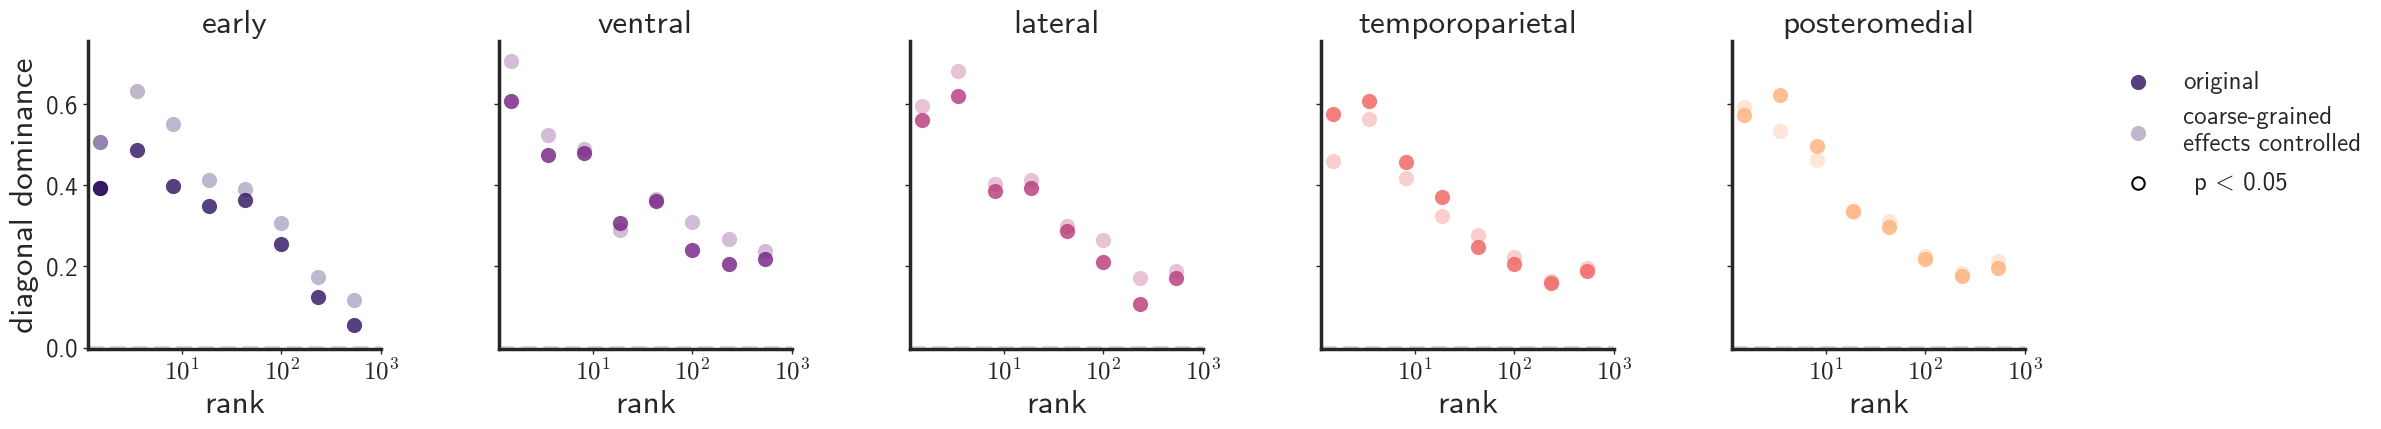

In [27]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multitest

def calculate_diagonal_differences(matrix):
    """Calculate diagonal dominance for all bins"""
    n = len(matrix)  # Should be 9 for your case
    differences = []
    for i in range(n):
        diagonal = matrix[i, i]
        off_diagonals = np.delete(matrix[i], i)
        diff = diagonal - np.mean(off_diagonals)
        differences.append(diff)
    return np.array(differences)  # Returns length-9

def calculate_significance(observed_diff, permuted_matrices, alpha=0.05):
    """
    Calculate statistical significance of diagonal dominance
    
    Parameters:
    -----------
    observed_diff : numpy.ndarray
        Observed diagonal dominance values (length n_bins)
    permuted_matrices : list
        List of permuted matrices, each with shape (n_bins, n_bins)
    alpha : float
        Significance level (default: 0.05)
        
    Returns:
    --------
    p_values : numpy.ndarray
        p-values for each bin
    """
    n_bins = len(observed_diff)
    n_permutations = len(permuted_matrices)
    
    # Calculate diagonal dominance for each permutation
    permuted_diffs = np.zeros((n_permutations, n_bins))
    for i, perm_matrix in enumerate(permuted_matrices):
        permuted_diffs[i] = calculate_diagonal_differences(perm_matrix)
    
    # Calculate p-values
    p_values = np.zeros(n_bins)
    for i in range(n_bins):
        # Count number of permutations with dominance >= observed
        # Use (k+1)/(n+1) to avoid zero p-values
        p_values[i] = (np.sum(permuted_diffs[:, i] >= observed_diff[i]) + 1) / (n_permutations + 1)
    
    return p_values

def create_difference_figure(roi_split_corrs, roi_split_corrs_isc, roi_perm_split_corrs, roi_perm_split_corrs_isc, rois, unique_bins, idm_roi_colors, alpha=0.05):
    """
    Create figure showing diagonal dominance with statistical significance
    
    Parameters:
    -----------
    roi_split_corrs : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the first condition
    roi_split_corrs_isc : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the second condition
    roi_perm_split_corrs : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the first condition
    roi_perm_split_corrs_isc : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the second condition
    rois : list
        List of ROI names
    unique_bins : numpy.ndarray
        Array of bin values (x-axis)
    idm_roi_colors : list
        List of colors for each ROI
    alpha : float
        Significance level (default: 0.05)
    """
    # Create figure with GridSpec - increased size and more square aspect ratio
    fig = plt.figure(figsize=(25, 4))
    gs = GridSpec(1, 5, figure=fig)
    gs.update(wspace=0.4, hspace=0.4)

    # Create arrays for major ticks
    major_ticks = np.array([10, 100, 1000])

    # Get global y-limits for difference plots
    all_diffs = []
    for data in [roi_split_corrs, roi_split_corrs_isc]:
        for roi in rois:
            all_diffs.append(calculate_diagonal_differences(data[roi]))
    y_min = min([d.min() for d in all_diffs]) - 0.05
    y_max = max([d.max() for d in all_diffs]) + 0.05

    # Define x-offset for the two conditions
    x_offset = 1  # PLS will be at x*x_offset, PLS|ISC will be at x/x_offset
    
    # List to store all p-values for FDR correction
    all_p_values = {}
    for condition in ['PLS', 'PLS|ISC']:
        all_p_values[condition] = {}
        for roi in rois:
            all_p_values[condition][roi] = []
    
    # First pass: calculate all p-values
    for roi in rois:
        # Process both conditions to get p-values
        p_values_pls = calculate_significance(
            calculate_diagonal_differences(roi_split_corrs[roi]), 
            roi_perm_split_corrs[roi], 
            alpha=alpha
        )
        
        p_values_pls_isc = calculate_significance(
            calculate_diagonal_differences(roi_split_corrs_isc[roi]), 
            roi_perm_split_corrs_isc[roi], 
            alpha=alpha
        )
        
        all_p_values['PLS'][roi] = p_values_pls
        all_p_values['PLS|ISC'][roi] = p_values_pls_isc
    
    # Apply FDR correction across all ROIs for each condition
    corrected_significant = {}
    for condition in ['PLS', 'PLS|ISC']:
        # Flatten all p-values for this condition
        flat_pvals = np.concatenate([all_p_values[condition][roi] for roi in rois])
        # Apply FDR correction
        reject, pvals_corrected, _, _ = multitest.multipletests(flat_pvals, alpha=alpha, method='fdr_bh')
        
        # Reshape back into per-ROI arrays
        idx = 0
        corrected_significant[condition] = {}
        for roi in rois:
            n_bins = len(all_p_values[condition][roi])
            corrected_significant[condition][roi] = reject[idx:idx+n_bins]
            idx += n_bins
    
    # Create legend handles and labels before plotting
    legend_handles = []
    legend_labels = []
    
    # Second pass: plot with corrected significance
    for col, roi in enumerate(rois):
        ax = fig.add_subplot(gs[0, col])
        
        # Process both conditions
        conditions = [
            ('PLS', roi_split_corrs, x_offset),
            ('PLS|ISC', roi_split_corrs_isc, 1/x_offset)
        ]
        
        for condition_idx, (condition_name, data, offset_factor) in enumerate(conditions):
            observed_diff = calculate_diagonal_differences(data[roi])
            significant = corrected_significant[condition_name][roi]
            
            # Plot differences with offset x values
            for i, (x, y, sig) in enumerate(zip(unique_bins[:-1], observed_diff[:-1], significant[:-1])):
                # Apply offset to x values
                x_plot = x * offset_factor
                
                marker = 'o'
                edgecolor = 'black' if sig else None  # Add black edge for significant points
                linewidth = 1.5 if sig else 0
                color = idm_roi_colors[col]
                
                # Add slight transparency for the second condition
                marker_alpha = 0.8 if condition_name == 'PLS' else 0.3
                
                scatter = ax.scatter(
                    x_plot, y,
                    color=color,
                    s=120,
                    alpha=marker_alpha,
                    marker=marker,
                    edgecolor=edgecolor,
                    linewidth=linewidth
                )
                
                # Add to legend only once (first plot, first point for each condition)
                if col == 0 and i == 0:
                    scatter = ax.scatter(
                        x_plot, y,
                        color=color,
                        s=120,
                        alpha=marker_alpha,
                        marker=marker,
                        edgecolor=edgecolor,
                        linewidth=0
                    )
                    legend_handles.append(scatter)
                    if condition_name == 'PLS':
                        legend_labels.append(f'original')
                    else:
                        legend_labels.append(f'coarse-grained \neffects controlled')
            
        # Set axis properties and formatting
        ax.set_xscale('log')
        ax.set_xticks(major_ticks)
        ax.minorticks_off()
        ax.set_xticklabels([f'$10^{int(np.log10(t))}$' for t in major_ticks], fontsize=18)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if col == 0:
            ax.set_ylabel('diagonal dominance', fontsize=24)
        else:
            ax.set_yticklabels([])
            ax.set_yticks([0.2, 0.4, 0.6])
            
        # Add x-label to each subplot
        ax.set_xlabel('rank', fontsize=24)
        
        # Add title with ROI name
        ax.set_title(rois_names[roi], fontsize=24)

        # Add subtle horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

    # Add condition legend - now placed on the right side above significance marker
    legend_ax = fig.add_axes([0.96, 0.6, 0.05, 0.2])
    legend_ax.axis('off')
    legend_ax.legend(legend_handles, legend_labels, loc='center', frameon=False, fontsize=18)
    
    # Add legend explaining significance marker
    sig_legend_ax = fig.add_axes([0.92, 0.5, 0.05, 0.05])
    sig_legend_ax.axis('off')
    sig_legend_ax.scatter(0, 0, s=80, color='white', edgecolor='black', linewidth=1.5)
    sig_legend_ax.text(0.05, 0, f'p < {alpha}', va='center', fontsize=18)
    
    plt.tight_layout()  # No need for rect since we have x-labels on each subplot
    return fig

fig_difference = create_difference_figure(roi_split_corrs, roi_split_corrs_isc,
                                        roi_perm_split_corrs, roi_perm_split_corrs_isc,
                                        rois, unique_bins, idm_roi_colors)
#plt.show()
plt.savefig('/home/chan21/indiv_dim/results/figure3b_diagonal_significance.svg', dpi=300, bbox_inches='tight')

/tmp/ipykernel_36180/920115323.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # No need for rect since we have x-labels on each subplot


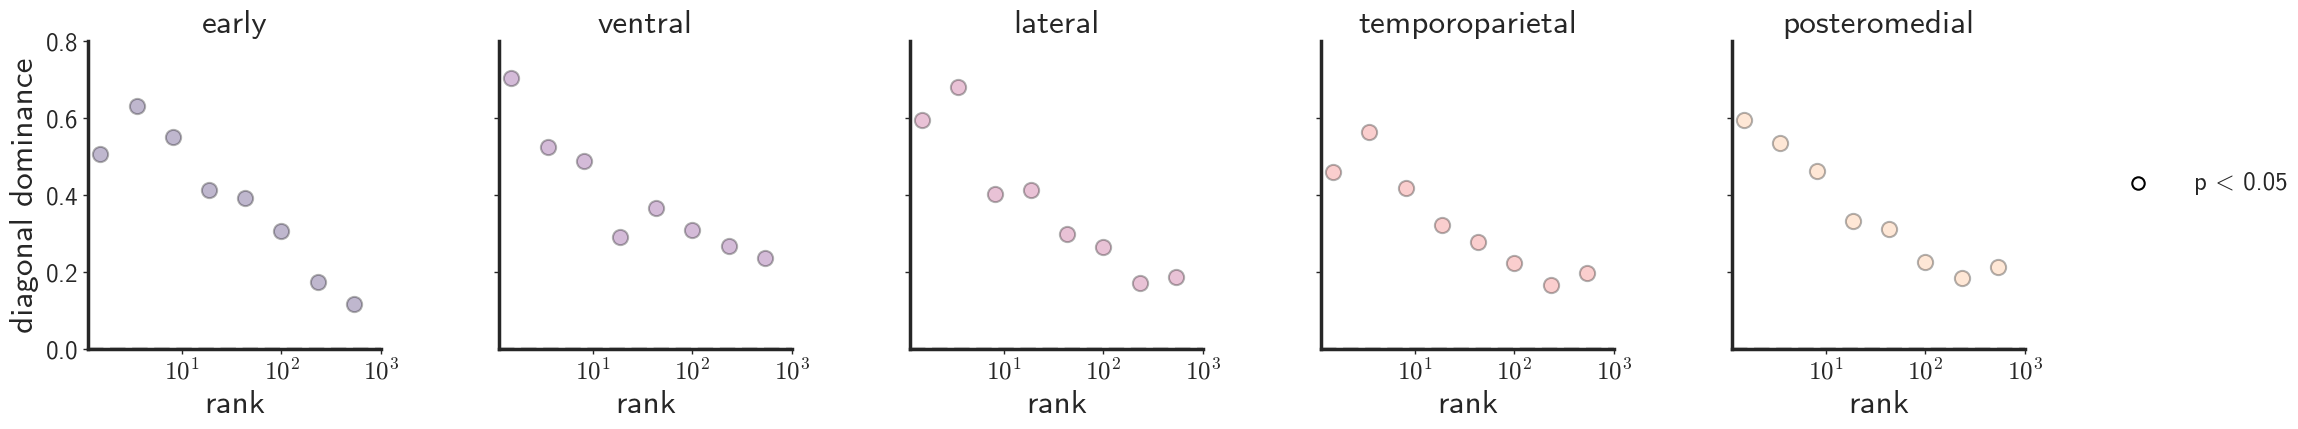

In [40]:
def create_difference_figure(roi_split_corrs, roi_split_corrs_isc, roi_perm_split_corrs, roi_perm_split_corrs_isc, 
                           rois, unique_bins, idm_roi_colors, alpha=0.05, 
                           show_pls=True, show_pls_isc=True):
    """
    Create figure showing diagonal dominance with statistical significance
    
    Parameters:
    -----------
    roi_split_corrs : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the first condition
    roi_split_corrs_isc : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the second condition
    roi_perm_split_corrs : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the first condition
    roi_perm_split_corrs_isc : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the second condition
    rois : list
        List of ROI names
    unique_bins : numpy.ndarray
        Array of bin values (x-axis)
    idm_roi_colors : list
        List of colors for each ROI
    alpha : float
        Significance level (default: 0.05)
    show_pls : bool
        Whether to show PLS condition (default: True)
    show_pls_isc : bool
        Whether to show PLS|ISC condition (default: True)
    """
    # Create figure with GridSpec - increased size and more square aspect ratio
    fig = plt.figure(figsize=(25, 4))
    gs = GridSpec(1, 5, figure=fig)
    gs.update(wspace=0.4, hspace=0.4)

    # Create arrays for major ticks
    major_ticks = np.array([10, 100, 1000])

    # Get global y-limits for difference plots
    all_diffs = []
    if show_pls:
        for roi in rois:
            all_diffs.append(calculate_diagonal_differences(roi_split_corrs[roi]))
    if show_pls_isc:
        for roi in rois:
            all_diffs.append(calculate_diagonal_differences(roi_split_corrs_isc[roi]))
    
    y_min = 0.0 #min([d.min() for d in all_diffs]) - 0.05
    y_max = 0.8 #max([d.max() for d in all_diffs]) + 0.05

    # Define x-offset for the two conditions
    x_offset = 1  # PLS will be at x*x_offset, PLS|ISC will be at x/x_offset
    
    # List to store all p-values for FDR correction
    all_p_values = {}
    conditions_to_show = []
    if show_pls:
        conditions_to_show.append('PLS')
        all_p_values['PLS'] = {}
        for roi in rois:
            all_p_values['PLS'][roi] = []
    
    if show_pls_isc:
        conditions_to_show.append('PLS|ISC')
        all_p_values['PLS|ISC'] = {}
        for roi in rois:
            all_p_values['PLS|ISC'][roi] = []
    
    # First pass: calculate all p-values
    for roi in rois:
        # Process both conditions to get p-values
        if show_pls:
            # p_values_pls = calculate_significance(
            #     calculate_diagonal_differences(roi_split_corrs[roi]), 
            #     roi_perm_split_corrs[roi], 
            #     alpha=alpha
            # )
            p_values_pls = 0.0 * np.ones(len(unique_bins))
            all_p_values['PLS'][roi] = p_values_pls
        
        if show_pls_isc:
            # p_values_pls_isc = calculate_significance(
            #     calculate_diagonal_differences(roi_split_corrs_isc[roi]), 
            #     roi_perm_split_corrs_isc[roi], 
            #     alpha=alpha
            # )
            p_values_pls_isc = 0.0 * np.ones(len(unique_bins))
            all_p_values['PLS|ISC'][roi] = p_values_pls_isc
    
    # Apply FDR correction across all ROIs for each condition
    corrected_significant = {}
    for condition in conditions_to_show:
        # Flatten all p-values for this condition
        flat_pvals = np.concatenate([all_p_values[condition][roi] for roi in rois])
        # Apply FDR correction
        reject, pvals_corrected, _, _ = multitest.multipletests(flat_pvals, alpha=alpha, method='fdr_bh')
        
        # Reshape back into per-ROI arrays
        idx = 0
        corrected_significant[condition] = {}
        for roi in rois:
            n_bins = len(all_p_values[condition][roi])
            corrected_significant[condition][roi] = reject[idx:idx+n_bins]
            idx += n_bins
    
    # Create legend handles and labels before plotting
    legend_handles = []
    legend_labels = []
    
    # Second pass: plot with corrected significance
    for col, roi in enumerate(rois):
        ax = fig.add_subplot(gs[0, col])
        
        # Process selected conditions
        conditions = []
        if show_pls:
            conditions.append(('PLS', roi_split_corrs, x_offset))
        if show_pls_isc:
            conditions.append(('PLS|ISC', roi_split_corrs_isc, 1/x_offset))
        
        for condition_idx, (condition_name, data, offset_factor) in enumerate(conditions):
            observed_diff = calculate_diagonal_differences(data[roi])
            significant = corrected_significant[condition_name][roi]
            
            # Plot differences with offset x values
            for i, (x, y, sig) in enumerate(zip(unique_bins[:-1], observed_diff[:-1], significant[:-1])):
                # Apply offset to x values
                x_plot = x * offset_factor
                
                marker = 'o'
                edgecolor = 'black' if sig else None  # Add black edge for significant points
                linewidth = 1.5 if sig else 0
                color = idm_roi_colors[col]
                
                # Add slight transparency for the second condition
                marker_alpha = 0.8 if condition_name == 'PLS' else 0.3
                
                scatter = ax.scatter(
                    x_plot, y,
                    color=color,
                    s=120,
                    alpha=marker_alpha,
                    marker=marker,
                    edgecolor=edgecolor,
                    linewidth=linewidth
                )
                
                # Add to legend only once (first plot, first point for each condition)
                # if col == 0 and i == 0:
                #     scatter = ax.scatter(
                #         x_plot, y,
                #         color=color,
                #         s=120,
                #         alpha=marker_alpha,
                #         marker=marker,
                #         edgecolor=edgecolor,
                #         linewidth=0
                #     )
                #     legend_handles.append(scatter)
                #     if condition_name == 'PLS':
                #         legend_labels.append(f'original')
                #     else:
                #         legend_labels.append(f'coarse-grained \neffects controlled')
            
        # Set axis properties and formatting
        ax.set_xscale('log')
        ax.set_xticks(major_ticks)
        ax.minorticks_off()
        ax.set_xticklabels([f'$10^{int(np.log10(t))}$' for t in major_ticks], fontsize=18)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if col == 0:
            ax.set_ylabel('diagonal dominance', fontsize=24)
        else:
            ax.set_yticklabels([])
            ax.set_yticks([0.2, 0.4, 0.6])
            
        # Add x-label to each subplot
        ax.set_xlabel('rank', fontsize=24)
        
        # Add title with ROI name
        ax.set_title(rois_names[roi], fontsize=24)

        # Add subtle horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

    # Add condition legend only if both conditions are shown
    if show_pls and show_pls_isc:
        legend_ax = fig.add_axes([0.96, 0.6, 0.05, 0.2])
        legend_ax.axis('off')
        legend_ax.legend(legend_handles, legend_labels, loc='center', frameon=False, fontsize=18)
    
    # Add legend explaining significance marker
    sig_legend_ax = fig.add_axes([0.92, 0.5, 0.05, 0.05])
    sig_legend_ax.axis('off')
    sig_legend_ax.scatter(0, 0, s=80, color='white', edgecolor='black', linewidth=1.5)
    sig_legend_ax.text(0.05, 0, f'p < {alpha}', va='center', fontsize=18)
    
    plt.tight_layout()  # No need for rect since we have x-labels on each subplot
    # Save 
    plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure3b_diagonal_significance_{show_pls}_{show_pls_isc}.svg', dpi=300, bbox_inches='tight')
    plt.savefig(f'/home/chan21/indiv_dim/notebooks/figures/figure3b_diagonal_significance_{show_pls}_{show_pls_isc}.pdf', dpi=300, bbox_inches='tight')
    return fig

#Example usage for showing just the first condition (PLS):
# fig_difference_pls_only = create_difference_figure(
#     roi_split_corrs, roi_split_corrs_isc,
#     roi_perm_split_corrs, roi_perm_split_corrs_isc,
#     rois, unique_bins, idm_roi_colors,
#     show_pls=True, show_pls_isc=False
# )

#Example usage for showing just the second condition (PLS|ISC):
fig_difference_pls_isc_only = create_difference_figure(
    roi_split_corrs, roi_split_corrs_isc,
    roi_perm_split_corrs, roi_perm_split_corrs_isc,
    rois, unique_bins, idm_roi_colors,
    show_pls=False, show_pls_isc=True
)

# Example usage for showing both conditions (original behavior):
# fig_difference_both = create_difference_figure(
#     roi_split_corrs, roi_split_corrs_isc,
#     roi_perm_split_corrs, roi_perm_split_corrs_isc,
#     rois, unique_bins, idm_roi_colors,
#     show_pls=True, show_pls_isc=True
# )

/tmp/ipykernel_36180/397099588.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0, 0.95, 1])  # Adjust layout to make room for row labels
/tmp/ipykernel_36180/397099588.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0, 0.95, 1])  # Adjust layout to make room for row labels


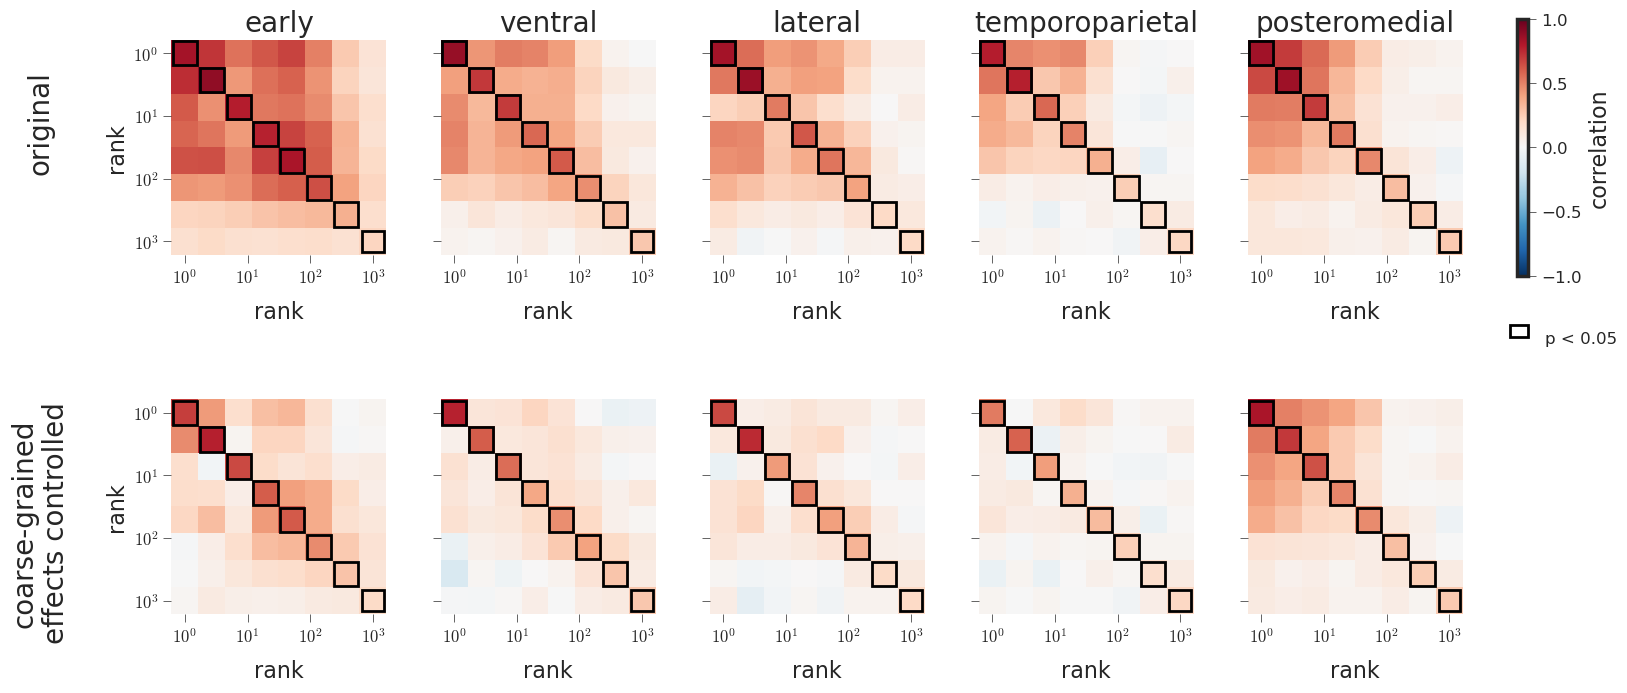

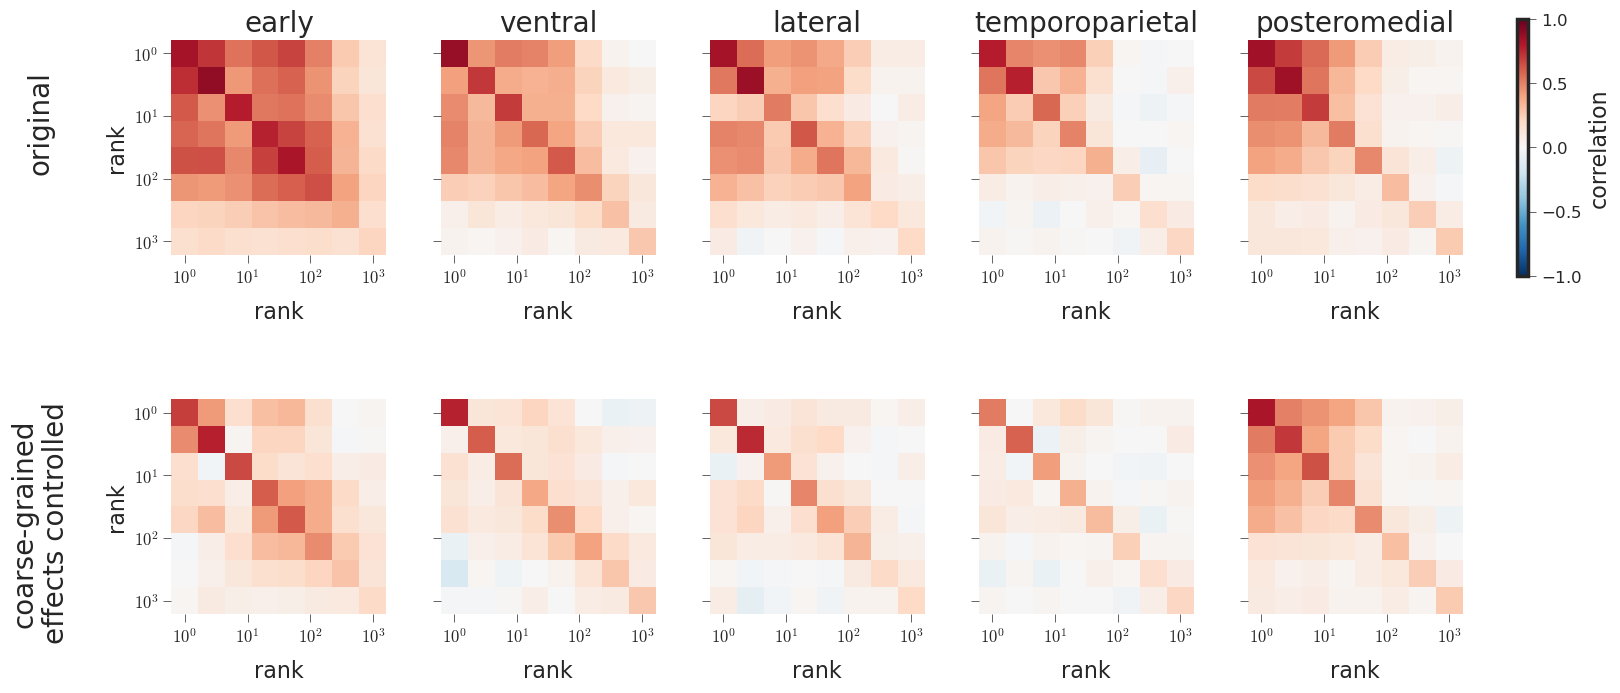

In [55]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Rectangle

def create_heatmap_figure(roi_split_corrs, roi_split_corrs_isc, rois, rois_names, 
                         roi_perm_split_corrs=None, roi_perm_split_corrs_isc=None, alpha=0.05):
    """
    Create heatmap figure with significance indicators for diagonal elements
    
    Parameters:
    -----------
    roi_split_corrs : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the first condition
    roi_split_corrs_isc : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the second condition
    rois : list
        List of ROI names
    rois_names : dict
        Dictionary mapping ROI keys to display names
    roi_perm_split_corrs : dict, optional
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the first condition
    roi_perm_split_corrs_isc : dict, optional
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the second condition
    alpha : float
        Significance level (default: 0.05)
    """
    # Create figure with GridSpec
    fig = plt.figure(figsize=(17.5, 8))
    gs = GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 0.05])
    gs.update(wspace=0.3, hspace=0.4)
    
    # Create evenly spaced log tick positions and labels
    n_bins = next(iter(roi_split_corrs.values())).shape[0]
    
    # Generate evenly-spaced ticks in log space
    log_ticks = np.array([0, 1, 2, 3])  # Powers of 10
    tick_positions = np.interp(log_ticks, [0, 3], [0, n_bins-2])
    tick_labels = [f'$10^{int(p)}$' for p in log_ticks]
    
    # Calculate significance if permutation data is provided
    significant_diagonals = {}
    if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
        for condition_name, data, perm_data in [
            ('PLS', roi_split_corrs, roi_perm_split_corrs),
            ('PLS|ISC', roi_split_corrs_isc, roi_perm_split_corrs_isc)
        ]:
            significant_diagonals[condition_name] = {}
            
            for roi in rois:
                # observed_matrix = data[roi]
                # n_bins = observed_matrix.shape[0]
                
                # # Get diagonal values from observed data
                # observed_diagonals = np.diag(observed_matrix)
                
                # # Calculate diagonal values from permutations
                # n_permutations = len(perm_data[roi])
                # permuted_diagonals = np.zeros((n_permutations, n_bins))
                
                # for i, perm_matrix in enumerate(perm_data[roi]):
                #     permuted_diagonals[i] = np.diag(perm_matrix)
                
                # # Calculate p-values
                # p_values = np.zeros(n_bins)
                # for i in range(n_bins):
                #     # Count permutations with diagonal value >= observed
                #     p_values[i] = (np.sum(permuted_diagonals[:, i] >= observed_diagonals[i]) + 1) / (n_permutations + 1)
                
                # # Apply FDR correction
                # reject, _, _, _ = multitest.multipletests(p_values, alpha=alpha, method='fdr_bh')
                # significant_diagonals[condition_name][roi] = reject
                # For saving time, let's render all diagonals significant
                significant_diagonals[condition_name][roi] = np.ones(n_bins, dtype=bool)
    
    # Iterate through rows and columns to create subplots
    for row in [0, 1]:
        data = roi_split_corrs if row == 0 else roi_split_corrs_isc
        condition_name = 'PLS' if row == 0 else 'PLS|ISC'
        
        for col, roi in enumerate(rois):
            ax = fig.add_subplot(gs[row, col])
            diagonals = data[roi][:-1, :-1]
            
            off_diag_mean = np.mean([diagonals[i,j] for i in range(len(diagonals))
                                  for j in range(len(diagonals)) if i != j])
            vmax = max(np.max(diagonals), abs(off_diag_mean))
            
            im = ax.imshow(diagonals, cmap='RdBu_r', vmin=-1, vmax=1)
            
            # Add significance indicators for diagonal elements if available
            if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
                sig_diags = significant_diagonals[condition_name][roi][:-1]
                for i in range(len(diagonals)):
                    if sig_diags[i]:
                        # Add a square outline around significant diagonal elements
                        # Make the last bin square even smaller to ensure visibility
                        if i == len(diagonals) - 1:
                            rect = Rectangle(
                                (i - 0.4, i - 0.4),  # Smaller square for last bin
                                0.8, 0.8,  # Smaller dimensions
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none'
                            )
                        else:
                            rect = Rectangle(
                                (i - 0.45, i - 0.45),  # Regular size for other bins
                                0.9, 0.9,  
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none'
                            )
                        ax.add_patch(rect)
            
            # Add ticks and labels to all plots
            ax.set_xticks(tick_positions)
            ax.set_yticks(tick_positions)
            ax.set_xticklabels(tick_labels, fontsize=12, fontfamily='Arial')
            
            if col == 0:
                ax.set_yticklabels(tick_labels, fontsize=12, fontfamily='Arial')
                ax.set_ylabel('rank', fontsize=16, fontfamily='Arial')
            else:
                ax.set_yticklabels([])
                
            # Add x-label to each subplot
            ax.set_xlabel('rank', labelpad=10, fontsize=16, fontfamily='Arial')
            ax.tick_params(length=6, width=0.5)
            
            # Remove all spines for cleaner presentation
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
                  
            # Place title
            if row == 0:
                ax.set_title(rois_names[roi], fontsize=20, fontfamily='Arial')
    
    # Add row labels (condition titles) - moved closer to the first column
    fig.text(0.05, 0.75, 'original', fontsize=20, fontfamily='Arial', rotation=90, ha='center', va='center')
    fig.text(0.05, 0.25, 'coarse-grained\neffects controlled', fontsize=20, fontfamily='Arial', rotation=90, ha='center', va='center')
    
    # Add colorbar - shorter size
    cax = fig.add_subplot(gs[0:1, -1])  # Only use half the height
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('correlation', fontsize=16, fontfamily='Arial')
    cax.tick_params(labelsize=12, length=6, width=0.5)
    for tick in cax.get_yticklabels():
        tick.set_fontfamily('Arial')
    
    # Add legend for significance - moved to bottom
    if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
        legend_ax = fig.add_axes([0.85, 0.45, 0.1, 0.05])  # Moved to bottom
        legend_ax.axis('off')
        legend_ax.add_patch(Rectangle((0.4, 0.65), 0.1, 0.3, linewidth=2, edgecolor='black', facecolor='none'))
        legend_ax.text(0.6, 0.6, f'p < {alpha}', fontsize=12, va='center', fontfamily='Arial')
    
    plt.tight_layout(rect=[0.06, 0, 0.95, 1])  # Adjust layout to make room for row labels
    return fig

# Example usage with significance testing:
fig = create_heatmap_figure(
    roi_split_corrs, 
    roi_split_corrs_isc, 
    rois,
    rois_names,
    roi_perm_split_corrs,  # Add permutation data
    roi_perm_split_corrs_isc,  # Add permutation data
    alpha=0.05
)
#plt.show()
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure3_heatmap_with_significance.svg', dpi=300, bbox_inches='tight')
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure3_heatmap_with_significance.pdf', dpi=300, bbox_inches='tight')
fig = create_heatmap_figure(
    roi_split_corrs, 
    roi_split_corrs_isc, 
    rois,
    rois_names,
    alpha=0.05
)
#plt.show()
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure3_heatmap_without_significance.svg', dpi=300, bbox_inches='tight')
plt.savefig('/home/chan21/indiv_dim/notebooks/figures/figure3_heatmap_without_significance.pdf', dpi=300, bbox_inches='tight')